In [4]:
from cProfile import label

# class that inherits from property based test
import numpy as np
import csv
import pandas as pd
from scipy.special import xlogy

pd.options.display.width = 240
import seaborn as sns
import scipy
import os
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylabel, xlabel
from numpy.f2py.cb_rules import cb_map
from qiskit import QuantumCircuit
from sympy.printing.pretty.pretty_symbology import line_width

In [5]:
def read_merged_data_to_dataframe(algorithm_name):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{algorithm_name}_merged_results.csv"
    return pd.read_csv(filename)

def clean(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (5.0 if x.name[3] else 10.0)).reset_index(name='Result')
        # df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum()/10.0).reset_index(name='Result')
        return df
    

In [6]:
qt_df = read_merged_data_to_dataframe("quantum_teleportation")
dj_df = read_merged_data_to_dataframe("deutsch_jozsa")
qft_df = read_merged_data_to_dataframe("quantum_fourier_transform")
qpe_df = read_merged_data_to_dataframe("quantum_phase_estimation")
grover_df = read_merged_data_to_dataframe("grovers_algorithm")

all_df = [qt_df, dj_df, qft_df, qpe_df, grover_df]
all_df = pd.concat(all_df)

qt_df_c = clean([qt_df])
dj_df_c = clean([dj_df])
qft_df_c = clean([qft_df])
qpe_df_c = clean([qpe_df])
grover_df_c = clean([grover_df])
all_df_c = clean([all_df])

In [7]:
# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_stats(df, group_by="Number of Properties", filter_by_feature=None, filter_by_values=None, feature_str="Result"):
    failure_rate = df[df['Equivalent'] == False]
    pass_rate = df[df['Equivalent'] == True]
    
    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
            pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]
        
    print("Not Equivalent")
    
    if group_by is not None:
        print("STD NE")
        print(failure_rate.groupby(group_by)[feature_str].std())
        print("Median NE")
        print(failure_rate.groupby(group_by)[feature_str].median())
        print("Mean NE")
        print(failure_rate.groupby(group_by)[feature_str].mean())
        print("Pearson Correlation Coefficient NE")
        print(scipy.stats.spearmanr(failure_rate[group_by], failure_rate[feature_str], alternative='two-sided'))
    else:
        if feature_str == "Time Taken":
            print(failure_rate[['Algorithm', feature_str, "Result"]])
        else:
            print("STD NE")
            print(failure_rate[feature_str].std())
            print("Median NE")
            print(failure_rate[feature_str].median())
            print("Mean NE")
            print(failure_rate[feature_str].mean())
    
    print("Equivalent")
    
    if group_by is not None:
        print("STD E")
        print(pass_rate.groupby(group_by)[feature_str].std())
        print("Median E")
        print(pass_rate.groupby(group_by)[feature_str].median())
        print("Mean E")
        print(pass_rate.groupby(group_by)[feature_str].mean())
        print("Pearson Correlation Coefficient E")
        print(scipy.stats.spearmanr(pass_rate[group_by], pass_rate[feature_str], alternative='two-sided'))
    else:
        if feature_str == "Time Taken":
            print(pass_rate[['Algorithm', feature_str, "Result"]])
        else:
            print("STD E")
            print(pass_rate[feature_str].std())
            print("Median E")
            print(pass_rate[feature_str].median())
            print("Mean E")
            print(pass_rate[feature_str].mean())

# get_stats(all_df_c, group_by="Number of Measurements")
# get_standard_deviation(qt_df, divide_multiplier=1, group_by="Number of Properties")

Not Equivalent
STD NE
Number of Properties
1    0.223334
2    0.202358
3    0.156862
Name: Result, dtype: float64
Median NE
Number of Properties
1    0.6
2    0.8
3    0.9
Name: Result, dtype: float64
Mean NE
Number of Properties
1    0.554286
2    0.762540
3    0.852063
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.5323913674589874, pvalue=2.745390619365338e-70)
Equivalent
STD E
Number of Properties
1    0.116447
2    0.216024
3    0.282058
Name: Result, dtype: float64
Median E
Number of Properties
1    0.0
2    0.0
3    0.0
Name: Result, dtype: float64
Mean E
Number of Properties
1    0.044444
2    0.092698
3    0.123175
Name: Result, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.0765986920579574, pvalue=0.0185200535604627)


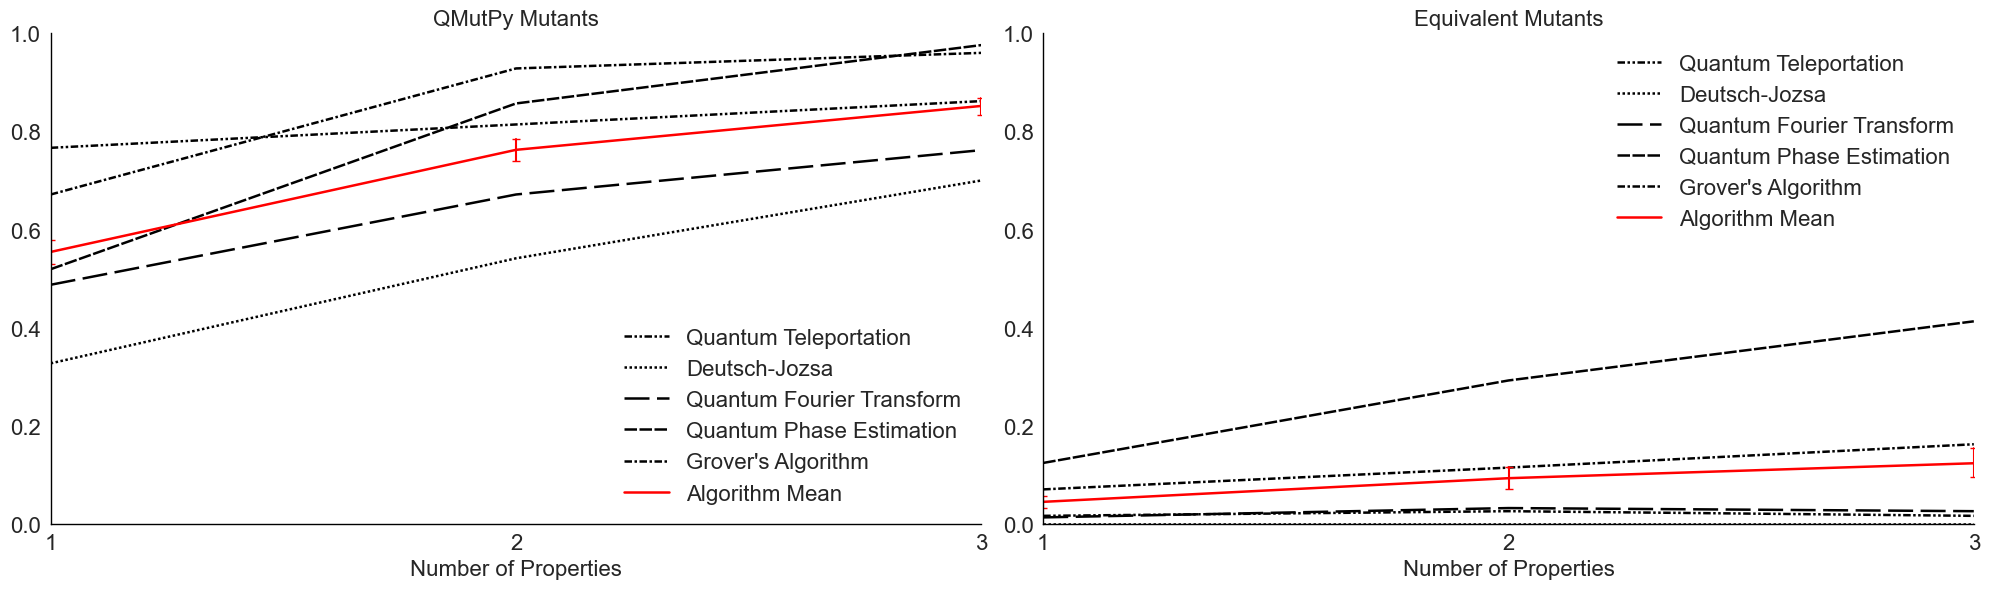

In [19]:
def plot_linegraph(dfs, dfs_names, feature_str, log_scale=False, cleaned_data=None, filter_by_feature=None, filter_by_values=None):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (3, 1, 1, 1, 1, 1),       # solid line
        (1, 1),             # dashed line
        (10, 3),      # dash-dot line
        (5, 1),             # dotted line
        (3, 1, 1, 1)      # dash-dot-dot line
    ]
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'QMutPy Mutants')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Equivalent Mutants')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [12, 25, 50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]
        
        # apply filters
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                df_non_equivalent = df_non_equivalent[df_non_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]
                df_equivalent = df_equivalent[df_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]

        df_non_equivalent = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        failure_rate['Result'] = failure_rate['Result']/10.0
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        
        df_equivalent = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        pass_rate['Result'] = pass_rate['Result']/5.0
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        idx += 1
    
    if cleaned_data is not None:
        failure_rate = cleaned_data[cleaned_data['Equivalent'] == False]
        pass_rate = cleaned_data[cleaned_data['Equivalent'] == True]
        
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
                pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]
        
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
        
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    if filter_by_feature is not None:
        # plt.savefig(f"{feature_str.replace(' ', '_')}_{filter_by_feature[0].replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
        plt.savefig(f"{feature_str.replace(' ', '_')}_{filter_by_feature[0].replace(' ', '_')}_failures_line.png", dpi=300, bbox_inches='tight')
    else:
        # plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
        plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.png", dpi=100, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


get_stats(all_df_c, group_by="Number of Properties")
plot_linegraph(dfs, dfs_names, "Number of Properties", log_scale=False, cleaned_data=all_df_c)

# Varying properties, (800, 1600, 3200) measurements

Not Equivalent
STD NE
Number of Properties
1    0.215145
2    0.152404
3    0.104496
Name: Result, dtype: float64
Median NE
Number of Properties
1    0.6
2    0.8
3    0.9
Name: Result, dtype: float64
Mean NE
Number of Properties
1    0.579048
2    0.784762
3    0.881905
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.607388411037276, pvalue=3.8121048909708607e-33)
Equivalent
STD E
Number of Properties
1    0.046646
2    0.083775
3    0.050128
Name: Result, dtype: float64
Median E
Number of Properties
1    0.0
2    0.0
3    0.0
Name: Result, dtype: float64
Mean E
Number of Properties
1    0.011429
2    0.032381
3    0.013333
Name: Result, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.013571710414986714, pvalue=0.8103865259326123)


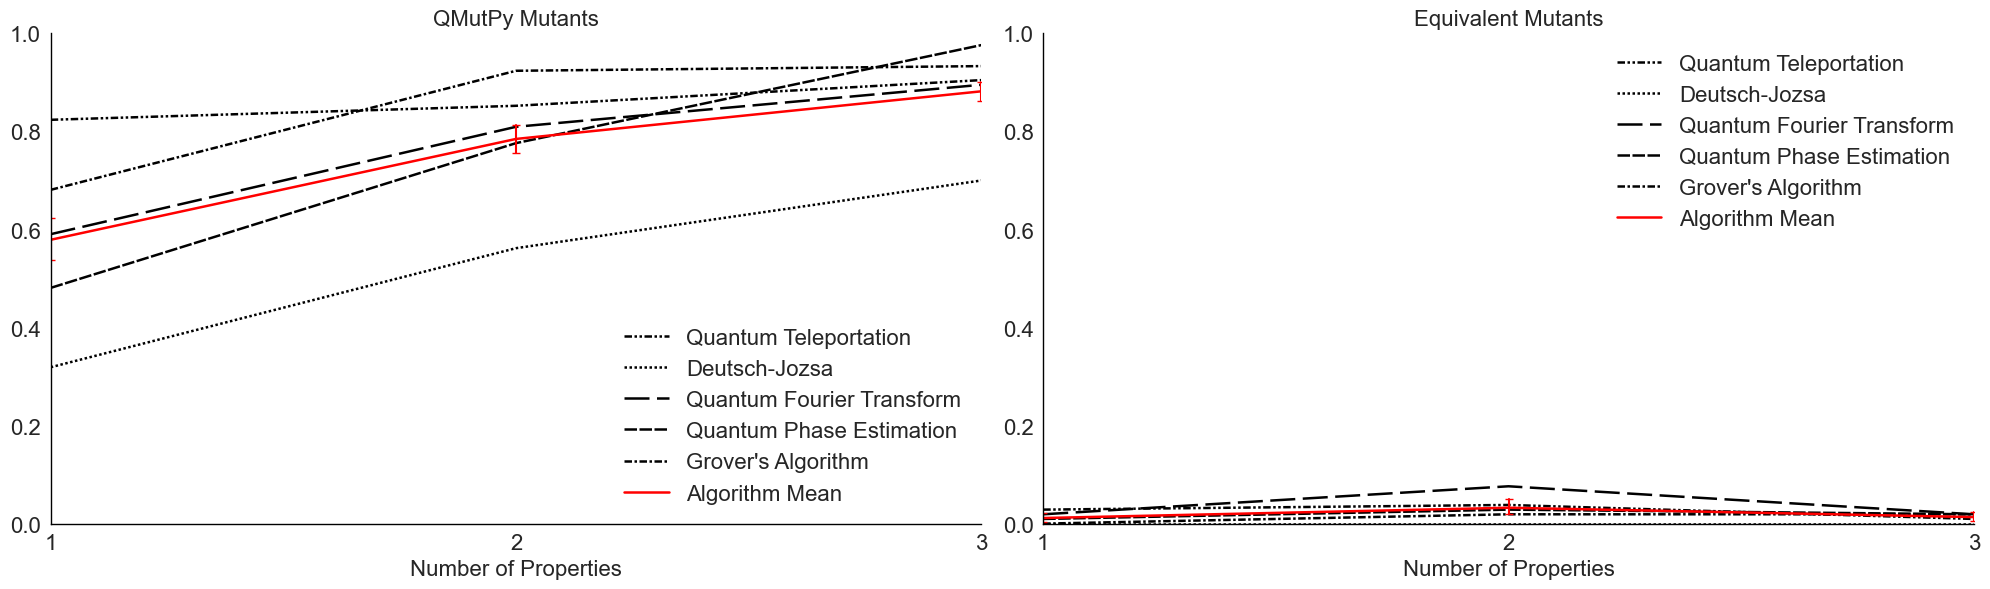

In [20]:
get_stats(all_df_c, group_by="Number of Properties", filter_by_feature=['Number of Measurements'], filter_by_values=[[800, 1600, 3200]])
plot_linegraph(dfs, dfs_names, "Number of Properties", log_scale=False, cleaned_data=all_df_c, filter_by_feature=['Number of Measurements'], filter_by_values=[[800, 1600, 3200]])

# Changing Number of Inputs

Not Equivalent
STD NE
Number of Inputs
1     0.231112
2     0.252707
4     0.228776
8     0.235463
16    0.227192
32    0.209785
64    0.219520
Name: Result, dtype: float64
Median NE
Number of Inputs
1     0.7
2     0.8
4     0.8
8     0.8
16    0.8
32    0.8
64    0.8
Name: Result, dtype: float64
Mean NE
Number of Inputs
1     0.651111
2     0.682222
4     0.722222
8     0.724444
16    0.747407
32    0.762222
64    0.771111
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.17262985451601845, pvalue=9.299596496079904e-08)
Equivalent
STD E
Number of Inputs
1     0.123215
2     0.148506
4     0.185524
8     0.219180
16    0.220808
32    0.259122
64    0.291672
Name: Result, dtype: float64
Median E
Number of Inputs
1     0.0
2     0.0
4     0.0
8     0.0
16    0.0
32    0.0
64    0.0
Name: Result, dtype: float64
Mean E
Number of Inputs
1     0.025185
2     0.045926
4     0.063704
8     0.084444
16    0.088889
32    0.137778
64    0.161481
Name:

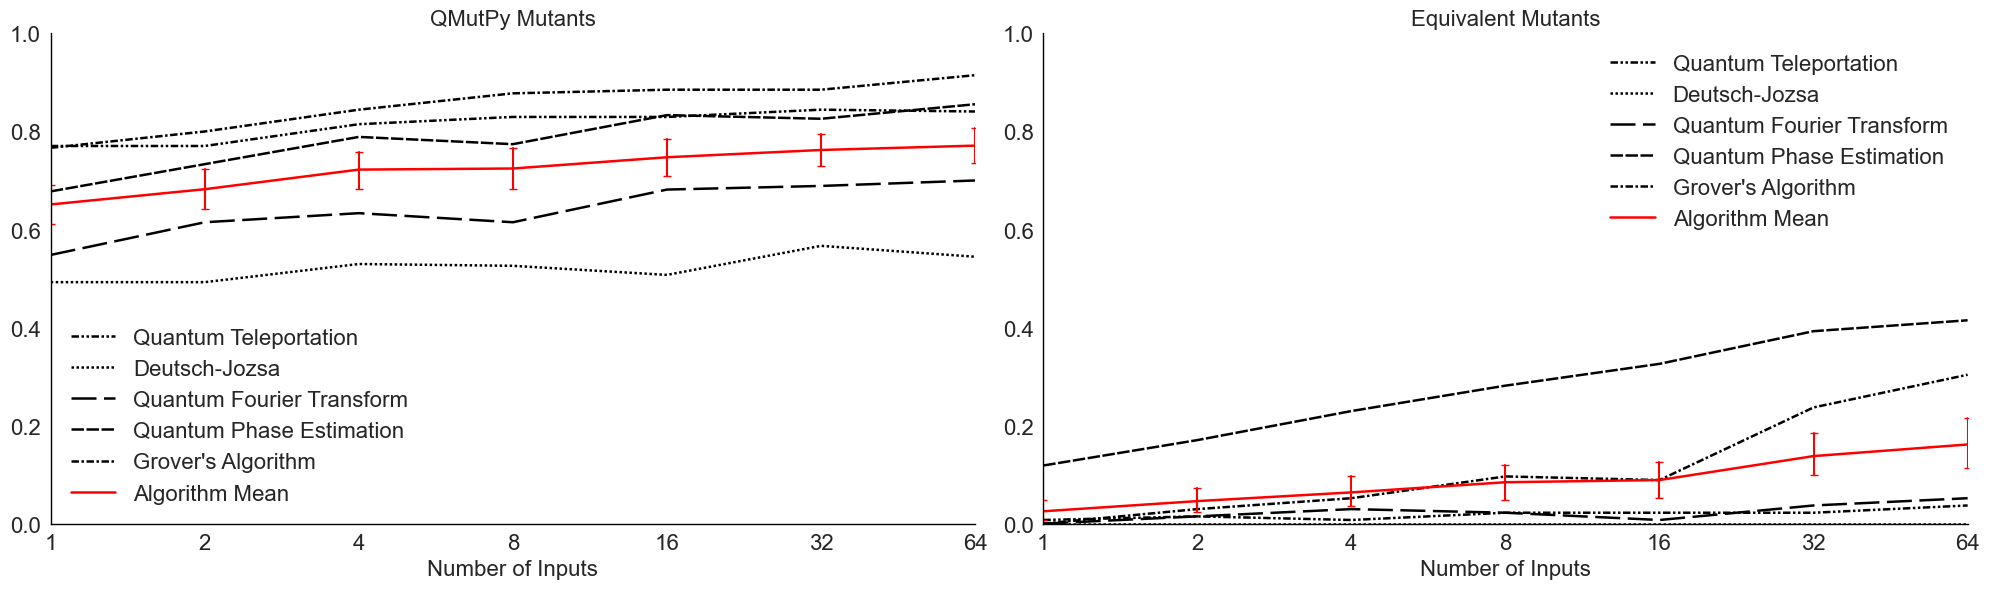

In [12]:
get_stats(all_df_c, group_by="Number of Inputs")
plot_linegraph(dfs, dfs_names, "Number of Inputs", log_scale=True, cleaned_data=all_df_c)

# Changing Number of Inputs, (800, 1600, 3200) measurements and 3 properties

Not Equivalent
STD NE
Number of Inputs
1     0.099043
2     0.097590
4     0.101419
8     0.101419
16    0.109978
32    0.113389
64    0.116292
Name: Result, dtype: float64
Median NE
Number of Inputs
1     0.9
2     0.9
4     0.9
8     0.9
16    0.9
32    0.9
64    0.9
Name: Result, dtype: float64
Mean NE
Number of Inputs
1     0.846667
2     0.866667
4     0.880000
8     0.880000
16    0.893333
32    0.900000
64    0.906667
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.2392669622256899, pvalue=0.013962546214054168)
Equivalent
STD E
Number of Inputs
1     0.000000
2     0.000000
4     0.082808
8     0.051640
16    0.000000
32    0.070373
64    0.051640
Name: Result, dtype: float64
Median E
Number of Inputs
1     0.0
2     0.0
4     0.0
8     0.0
16    0.0
32    0.0
64    0.0
Name: Result, dtype: float64
Mean E
Number of Inputs
1     0.000000
2     0.000000
4     0.040000
8     0.013333
16    0.000000
32    0.026667
64    0.013333
Name: R

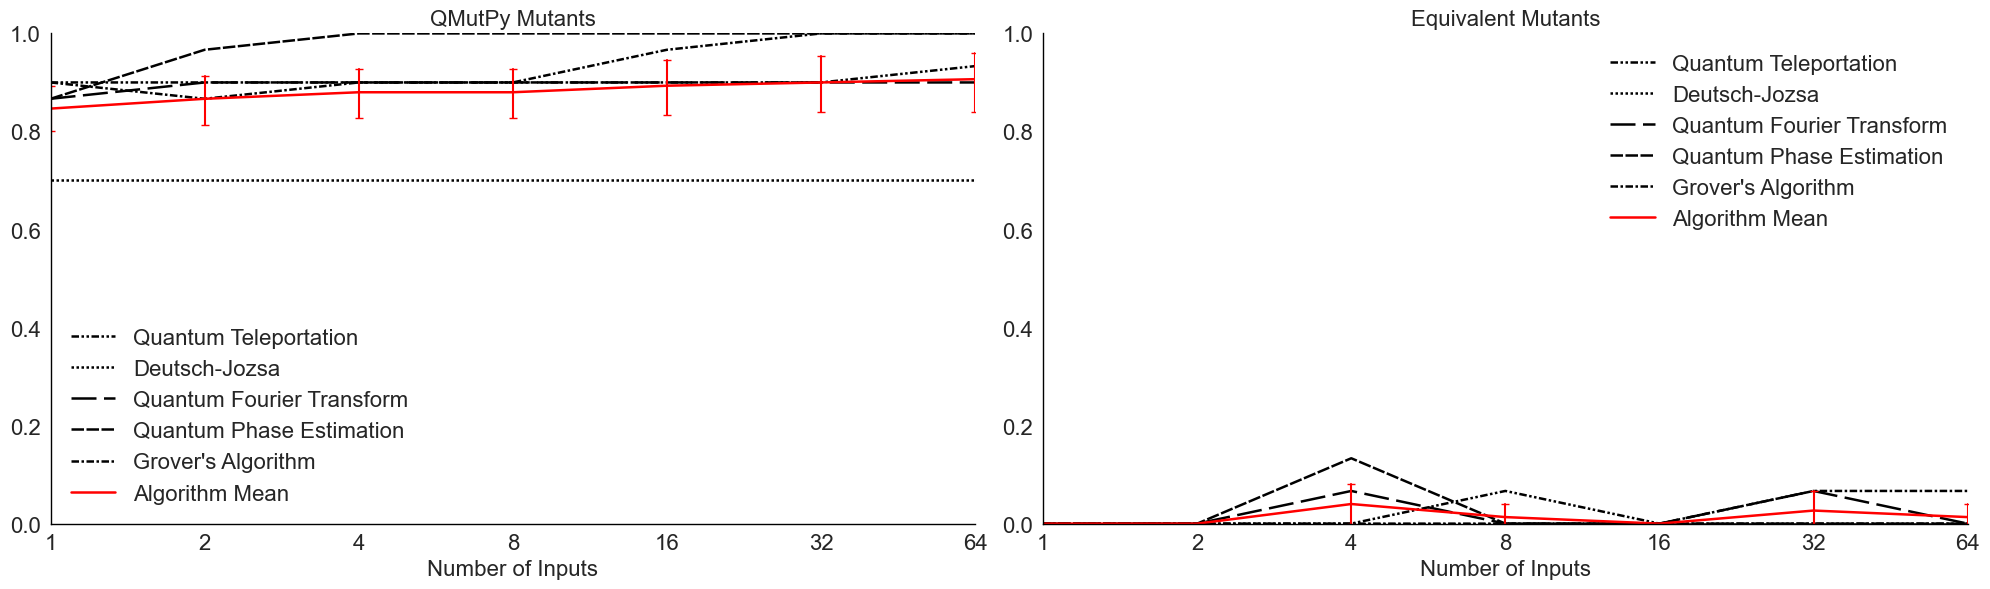

In [11]:
get_stats(all_df_c, group_by="Number of Inputs", filter_by_feature=['Number of Properties', 'Number of Measurements'], filter_by_values=[[3], [800,  1600, 3200]])
plot_linegraph(dfs, dfs_names, "Number of Inputs", log_scale=True, cleaned_data=all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements'], filter_by_values=[[3], [800, 1600, 3200]])

# Changing Number of Measurements

Not Equivalent
STD NE
Number of Measurements
12      0.272262
25      0.259853
50      0.230293
100     0.230829
200     0.213002
400     0.216672
800     0.213088
1600    0.207607
3200    0.200471
Name: Result, dtype: float64
Median NE
Number of Measurements
12      0.6
25      0.7
50      0.7
100     0.8
200     0.8
400     0.8
800     0.8
1600    0.8
3200    0.8
Name: Result, dtype: float64
Mean NE
Number of Measurements
12      0.602857
25      0.683810
50      0.715238
100     0.753333
200     0.756190
400     0.749524
800     0.751429
1600    0.749524
3200    0.744762
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.12070066078446125, pvalue=0.00019990610403280336)
Equivalent
STD E
Number of Measurements
12      0.326901
25      0.308250
50      0.288650
100     0.225190
200     0.167135
400     0.124330
800     0.053315
1600    0.071765
3200    0.062722
Name: Result, dtype: float64
Median E
Number of Measurements
12      0.0
25      

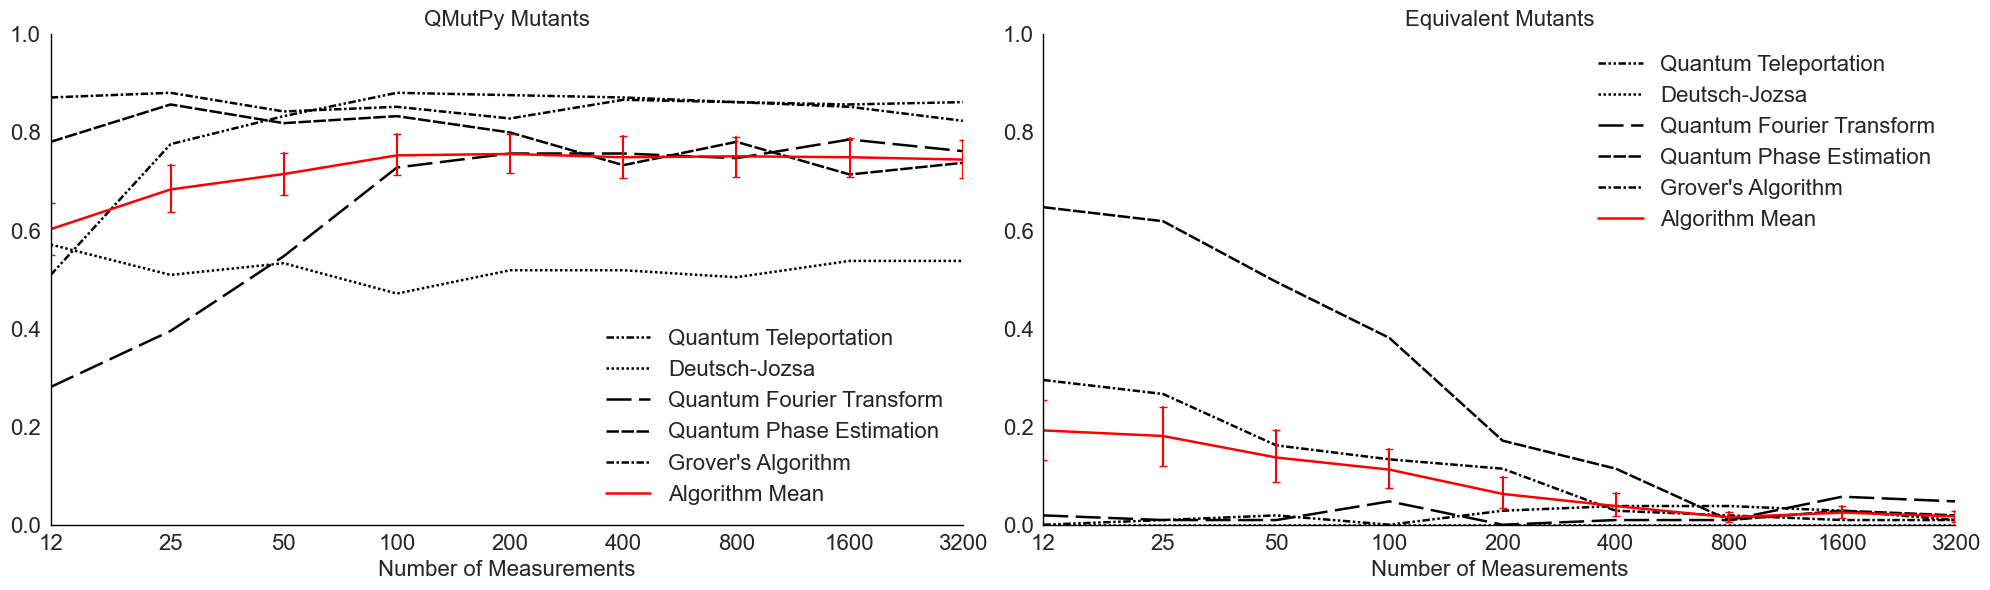

In [13]:
get_stats(all_df_c, group_by="Number of Measurements")
plot_linegraph(dfs, dfs_names, "Number of Measurements", log_scale=True, cleaned_data=all_df_c)

# Changing number of measurements, remove the equivalent mutants

Not Equivalent
STD NE
Number of Measurements
12      0.283461
25      0.257393
50      0.224798
100     0.224815
200     0.208964
400     0.214825
800     0.209417
1600    0.207935
3200    0.204425
Name: Result, dtype: float64
Median NE
Number of Measurements
12      0.700000
25      0.800000
50      0.888889
100     0.900000
200     0.900000
400     0.900000
800     0.900000
1600    0.900000
3200    0.900000
Name: Result, dtype: float64
Mean NE
Number of Measurements
12      0.669403
25      0.753515
50      0.791640
100     0.829509
200     0.836977
400     0.830204
800     0.830461
1600    0.832154
3200    0.826969
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.13815957440482096, pvalue=2.026270580440313e-05)
Equivalent
STD E
Number of Measurements
12      0.326901
25      0.308250
50      0.288650
100     0.225190
200     0.167135
400     0.124330
800     0.053315
1600    0.071765
3200    0.062722
Name: Result, dtype: float64
Median E

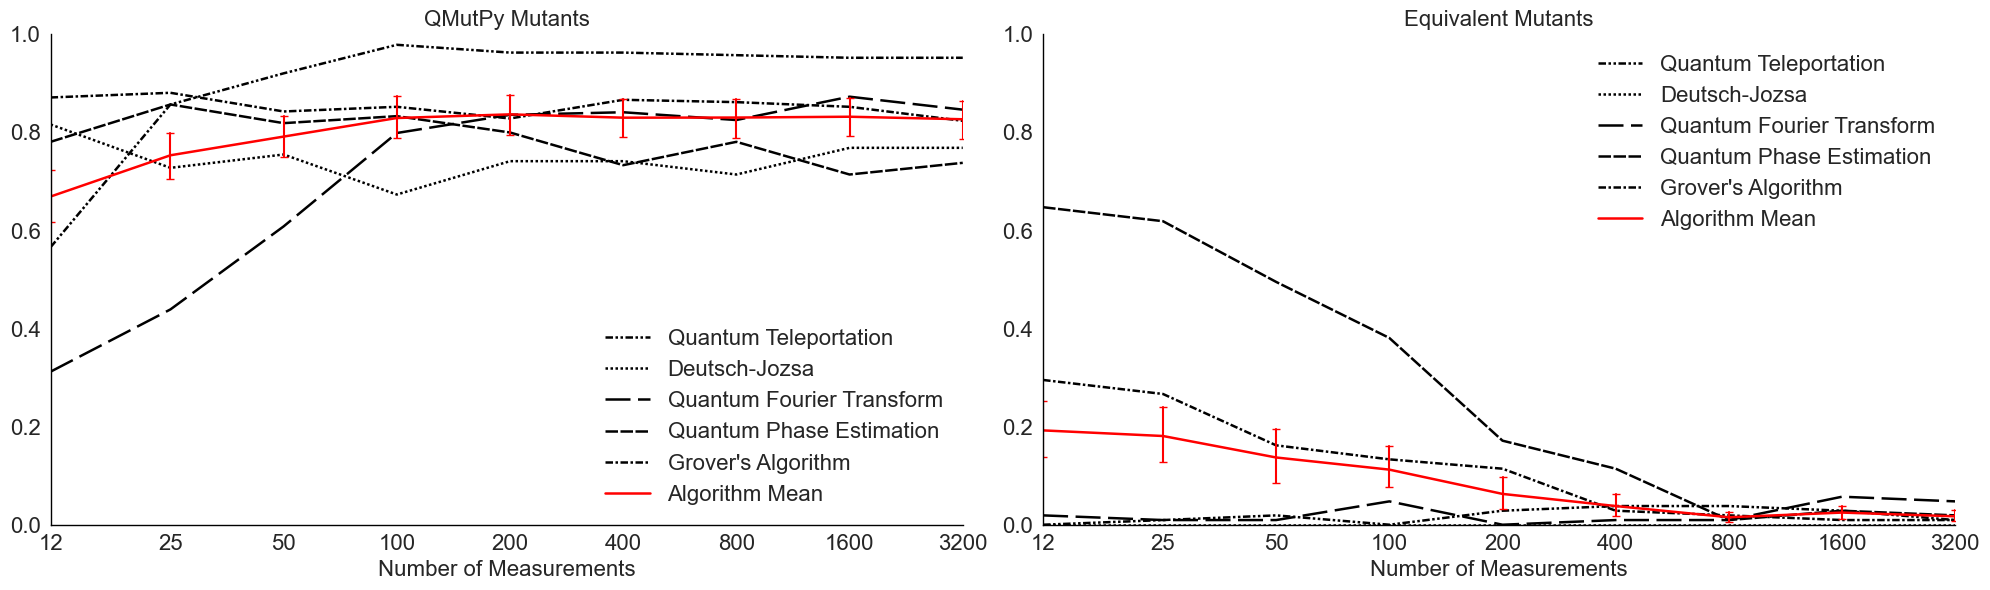

In [13]:
def get_divisor(algorithm):
    if algorithm == "quantum_teleportation":
        return 9.0
    elif algorithm == "deutsch_jozsa":
        return 7.0
    elif algorithm == "quantum_fourier_transform":
        return 9.0
    else:
        return 10.0

def clean2(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (5.0 if x.name[3] else get_divisor(x.name[4]))).reset_index(name='Result')
        # df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (5.0 if x.name[3] else 10.0)).reset_index(name='Result')
        # df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum()/10.0).reset_index(name='Result')
        return df

def plot_linegraph_rem_rows(dfs, dfs_names, feature_str, log_scale=False, cleaned_data=None, filter_by_feature=None, filter_by_values=None):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (3, 1, 1, 1, 1, 1),       # solid line
        (1, 1),             # dashed line
        (10, 3),      # dash-dot line
        (5, 1),             # dotted line
        (3, 1, 1, 1)      # dash-dot-dot line
    ]
    
    equivalent_mutants_in_ms = ["quantum_teleportation_m8",
                            "deutsch_jozsa_m1", "deutsch_jozsa_m2", "deutsch_jozsa_m7",
                            "quantum_fourier_transform_m9"
                            ] 
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'QMutPy Mutants')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Equivalent Mutants')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [12, 25, 50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        # remove the equivalent mutants from list
        algorithm_df = algorithm_df[~algorithm_df['Mutant Name'].isin(equivalent_mutants_in_ms)]
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]
        
        # apply filters
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                df_non_equivalent = df_non_equivalent[df_non_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]
                df_equivalent = df_equivalent[df_equivalent[filter_by_feature[i]].isin(filter_by_values[i])]

        divide_by = 10.0
        if algorithm_name == "Quantum Teleportation":
            divide_by = 9.0
        elif algorithm_name == "Deutsch-Jozsa":
            divide_by = 7.0
        elif algorithm_name == "Quantum Fourier Transform":
            divide_by = 9.0
            
        
        df_non_equivalent = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        failure_rate = df_non_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        failure_rate['Result'] = failure_rate['Result']/divide_by
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        
        df_equivalent = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
        pass_rate = df_equivalent.groupby(feature_str)['Result'].mean().reset_index(name='Result')
        pass_rate['Result'] = pass_rate['Result']/5.0
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        idx += 1
    
    if cleaned_data is not None:
        failure_rate = cleaned_data[cleaned_data['Equivalent'] == False]
        failure_rate = failure_rate[~failure_rate['Algorithm'].isin(equivalent_mutants_in_ms)]
        pass_rate = cleaned_data[cleaned_data['Equivalent'] == True]
        
        if filter_by_feature is not None:
            for i in range(len(filter_by_feature)):
                failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
                pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]
        
        sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
        
        sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Algorithm Mean", color="red", errorbar="ci", err_style="bars", err_kws={'capsize':3}, linewidth=1.8)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    if filter_by_feature is not None:
        plt.savefig(f"{feature_str.replace(' ', '_')}_{filter_by_feature[0].replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
    else:
        plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.svg", dpi=100, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]

all_df_c2 = clean2([all_df])

get_stats(all_df_c2, group_by="Number of Measurements")
plot_linegraph_rem_rows(dfs, dfs_names, "Number of Measurements", log_scale=True, cleaned_data=all_df_c2)

# Mutation score heatmap for each algorithm, and averaged heatmap

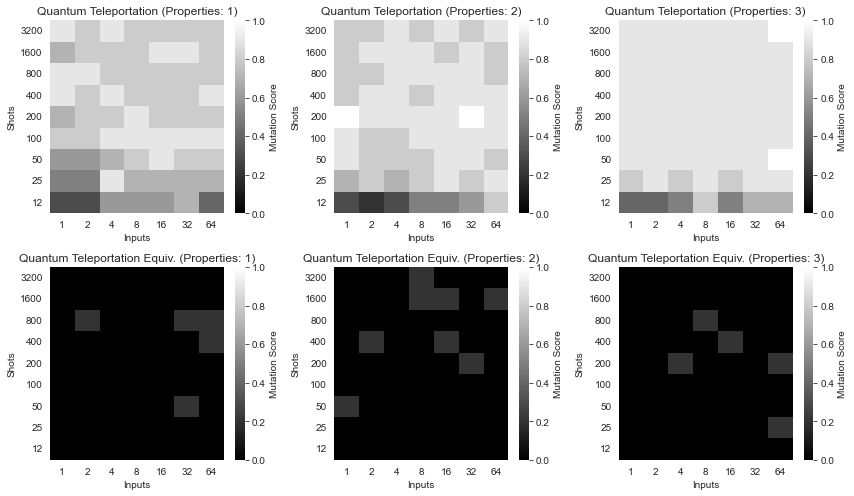

In [29]:
def plot_failures(df, algorithm_name, dp_format=".1f"):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(12, 7.5), sharey=False)
    
    # viridis or magma
    palette = sns.color_palette("gray", as_cmap=True)

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
                
        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]
        
        failure_rate = failure_rate / max_value

        sns.heatmap(failure_rate, annot=False, cmap=palette, ax=axes[0, i], fmt=dp_format, 
                    linewidth=0, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')
        axes[0, i].invert_yaxis()

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Result'].apply(lambda x: (x == 'Fail').sum()).unstack()
        
        grouped = df_subset.groupby(["Number of Measurements", "Number of Inputs"])
        result = grouped['Mutant Name'].nunique().reset_index()
        max_value = result['Mutant Name'].iloc[0]
        
        pass_rate = pass_rate / max_value
        
        sns.heatmap(pass_rate, annot=False, cmap=palette, ax=axes[1, i], fmt=dp_format, 
                    linewidth=0, vmin=0, vmax=1, cbar_kws={'label': 'Mutation Score'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')
        axes[1, i].invert_yaxis()

    plt.tight_layout()
    plt.savefig(f"{algorithm_name.replace(' ', '_')}_failures_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_failures(qt_df, "Quantum Teleportation")

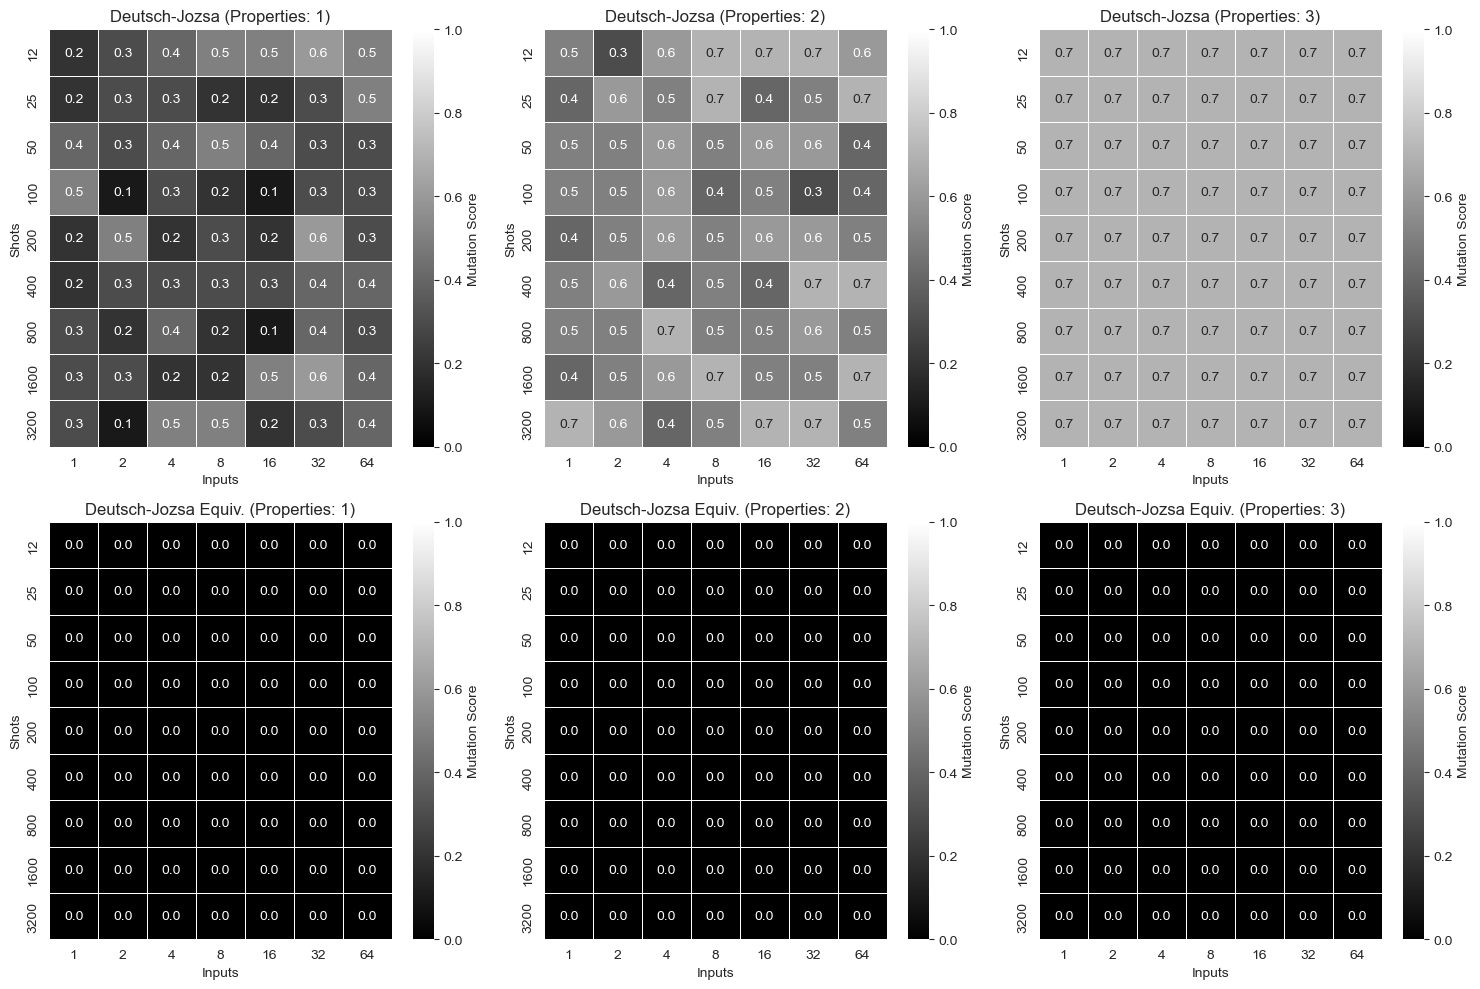

In [15]:
plot_failures(dj_df, "Deutsch-Jozsa")

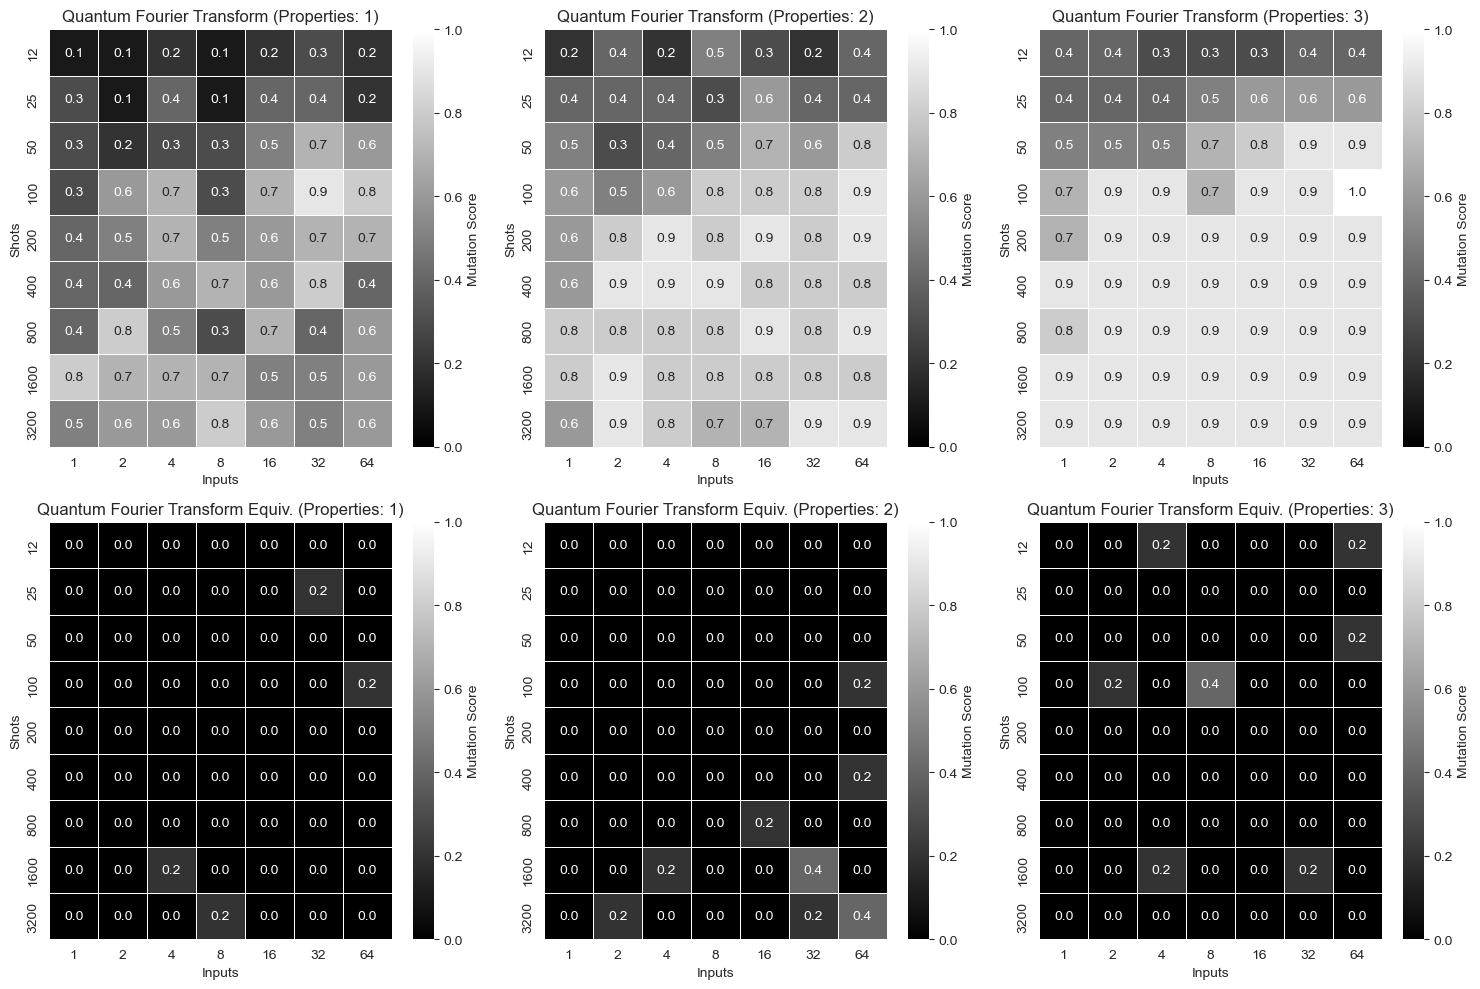

In [16]:
plot_failures(qft_df, "Quantum Fourier Transform")

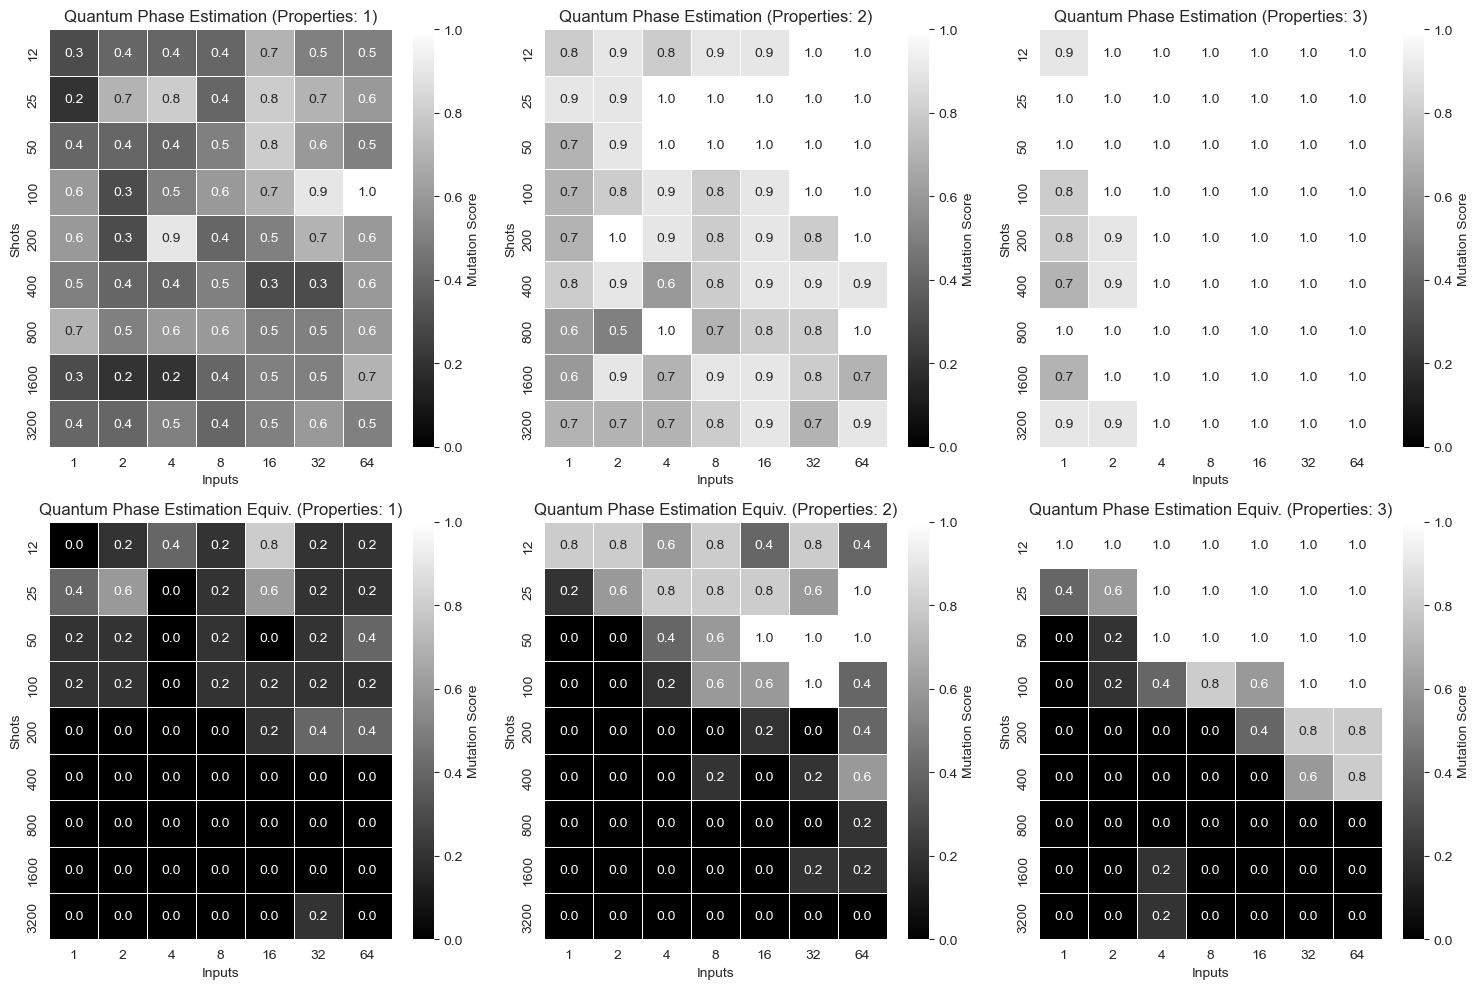

In [17]:
plot_failures(qpe_df, "Quantum Phase Estimation")

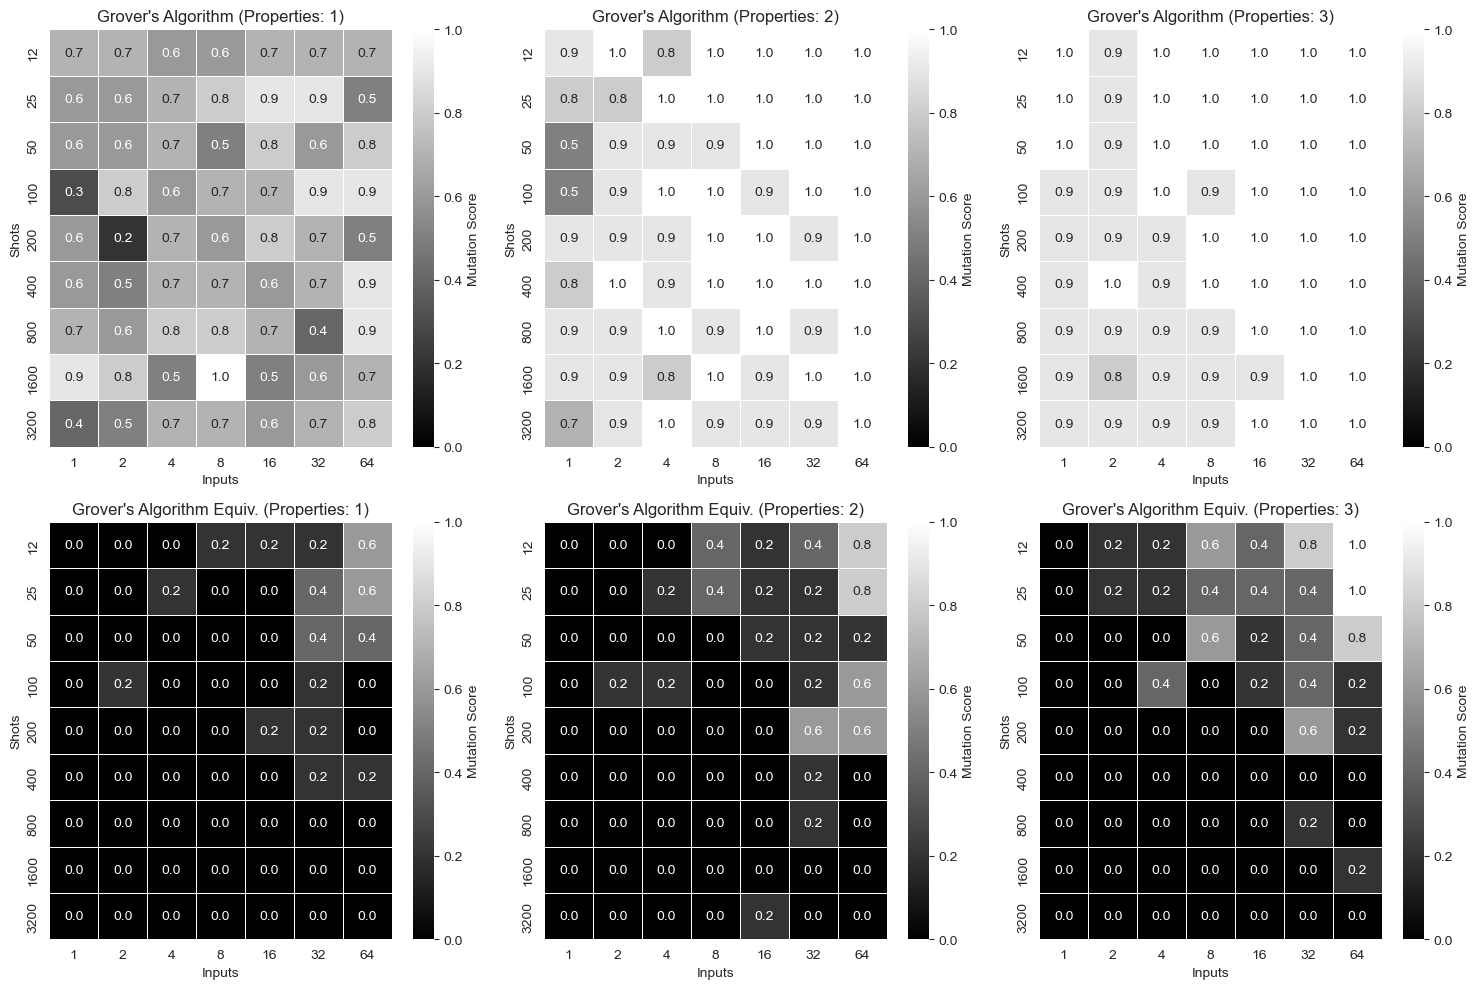

In [18]:
plot_failures(grover_df, "Grover's Algorithm")

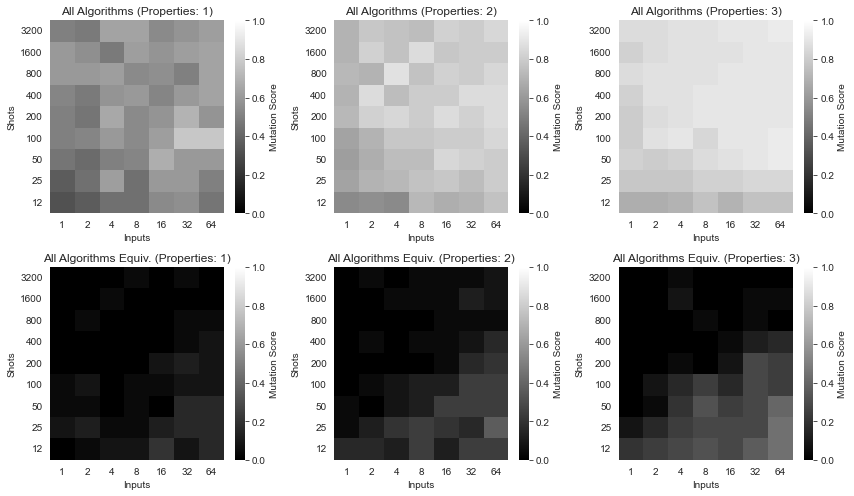

In [30]:
plot_failures(all_df, "All Algorithms", dp_format=".2f")

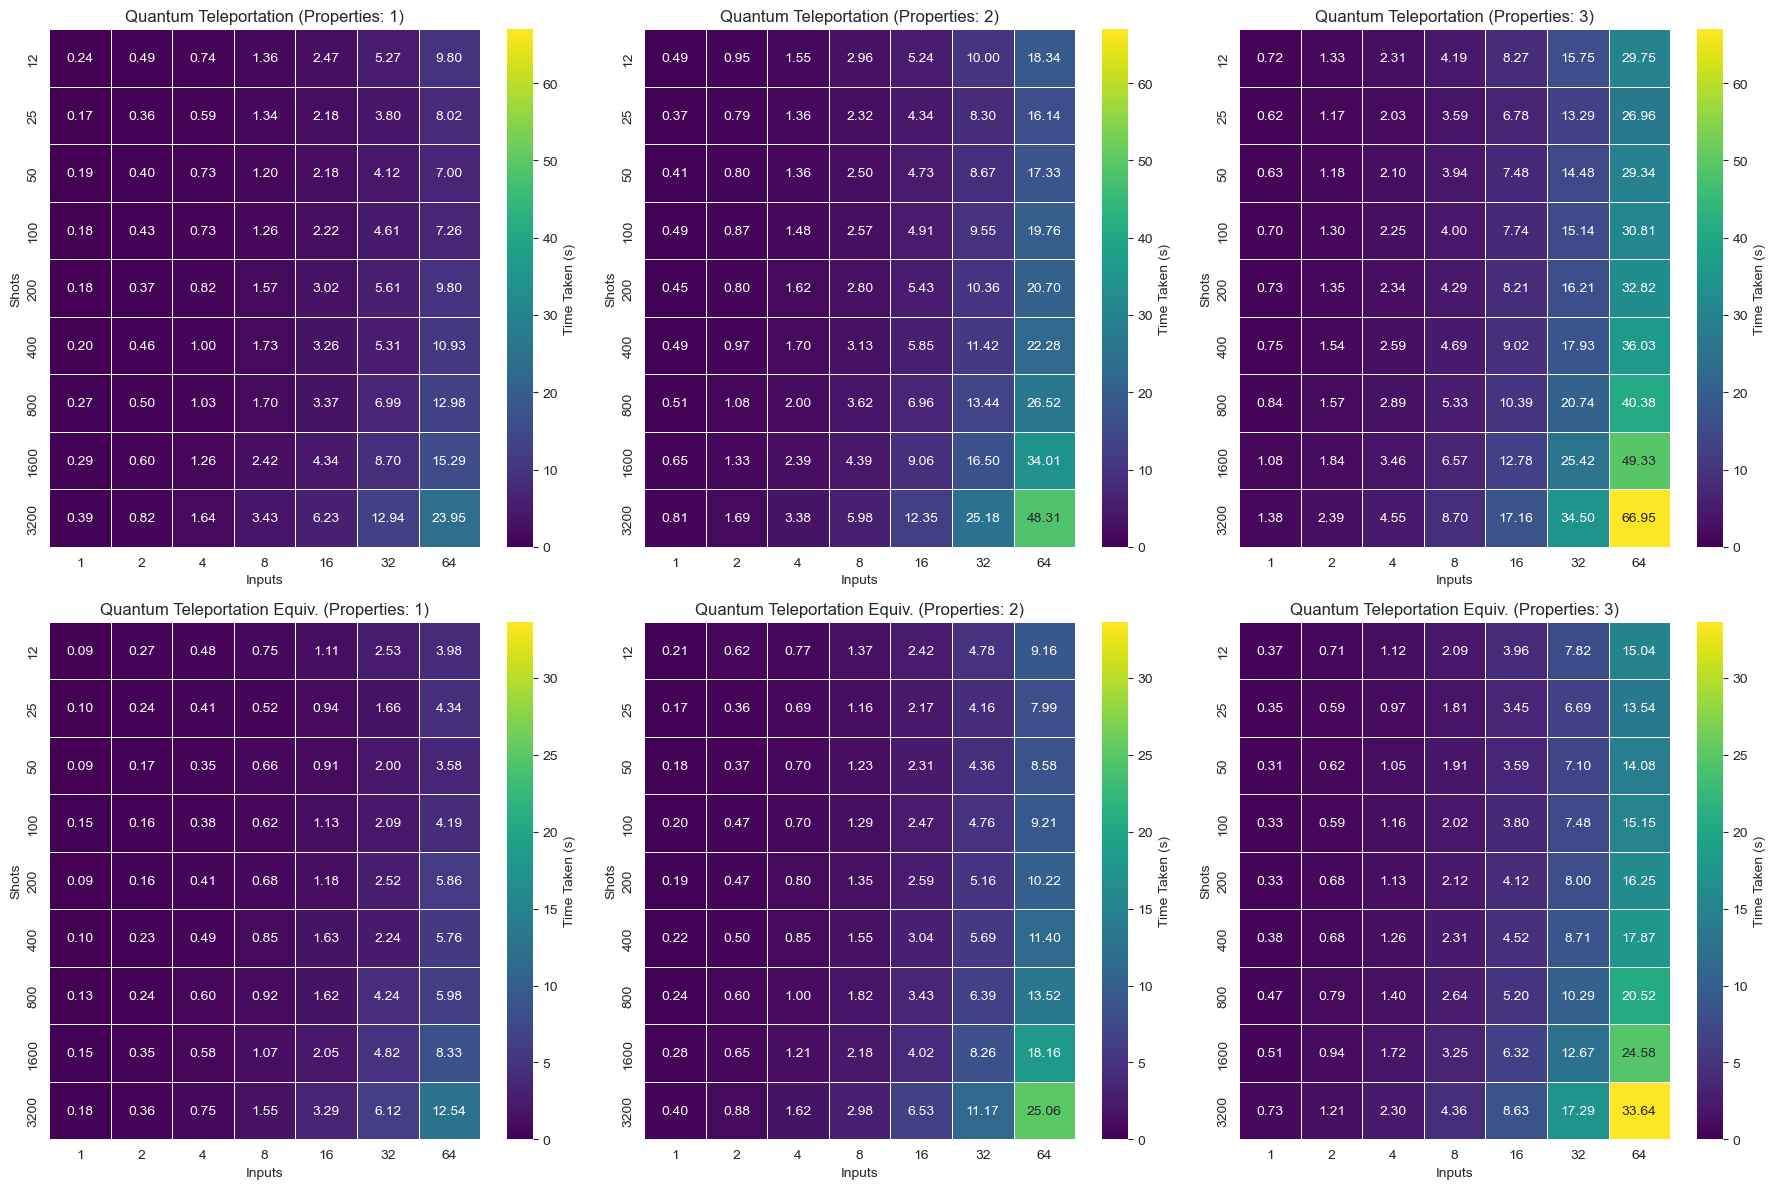

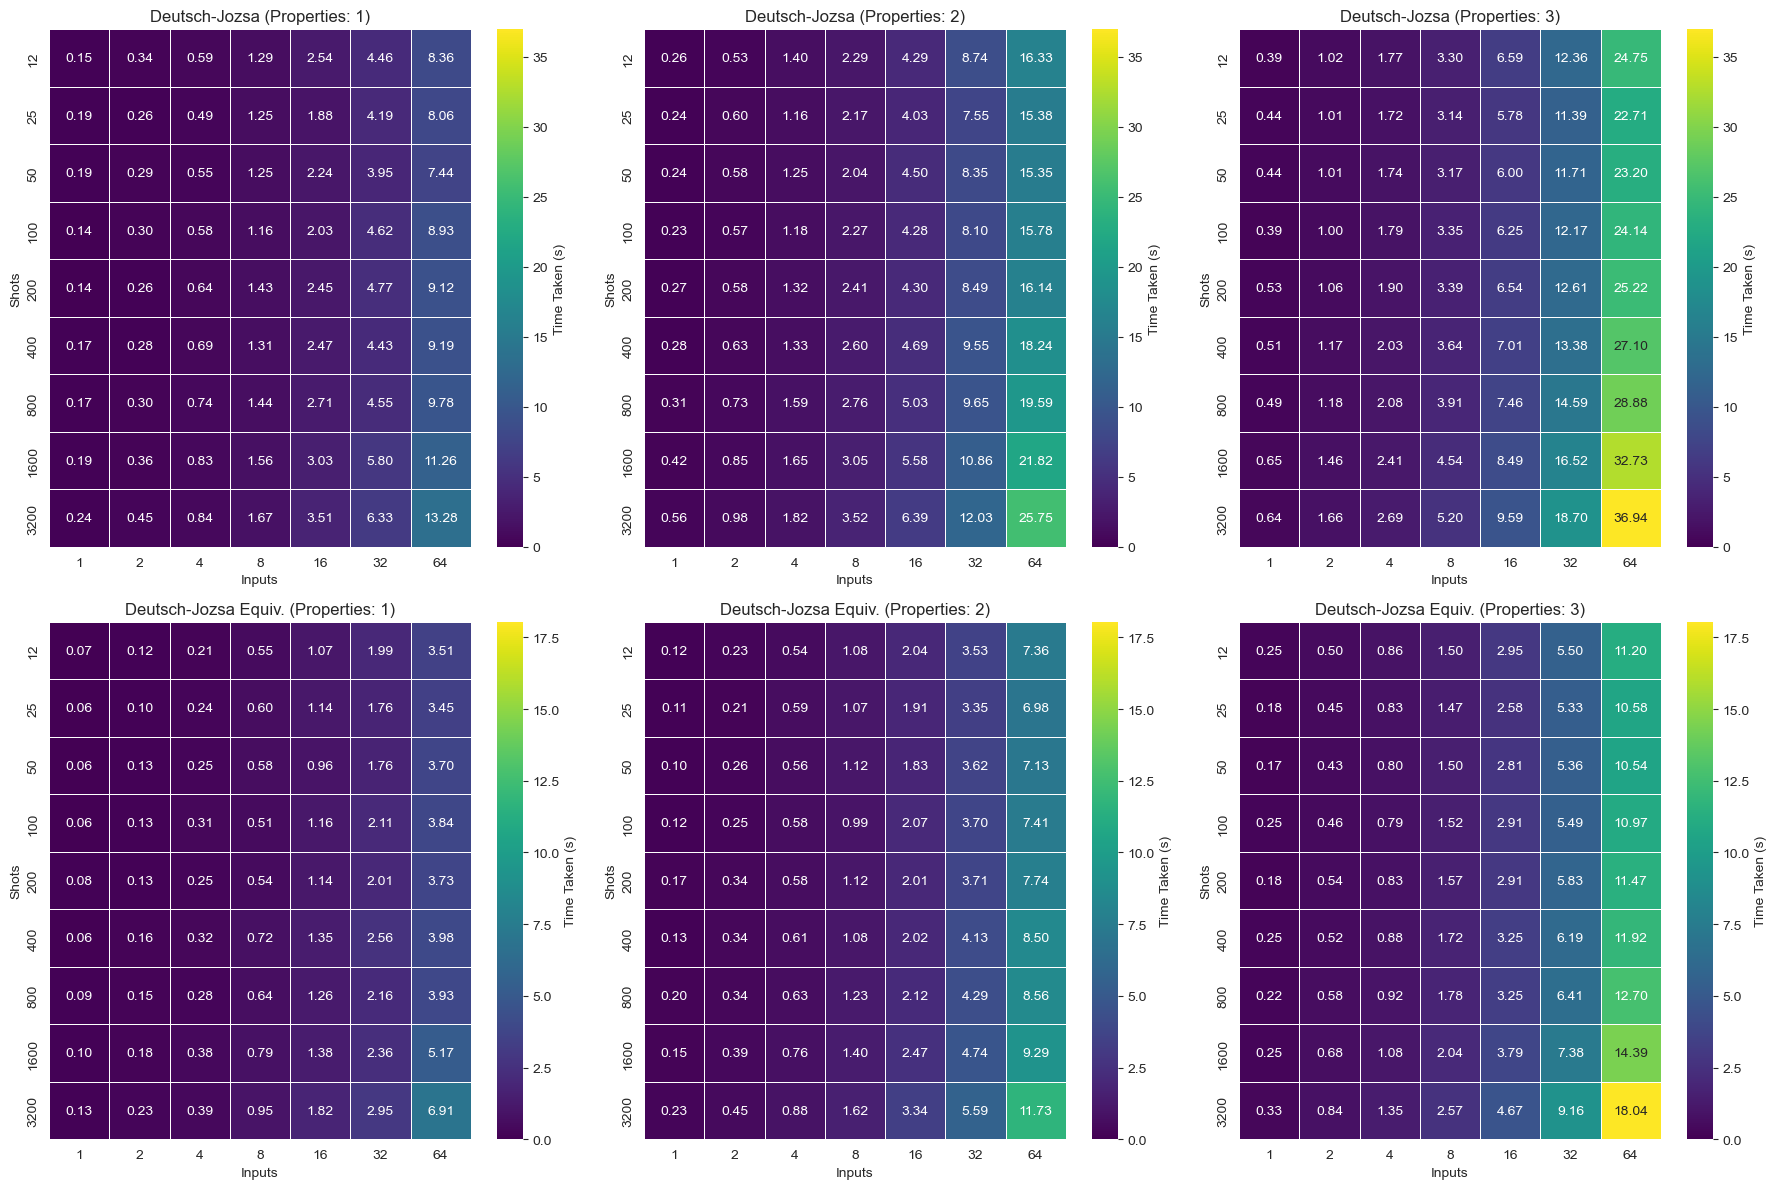

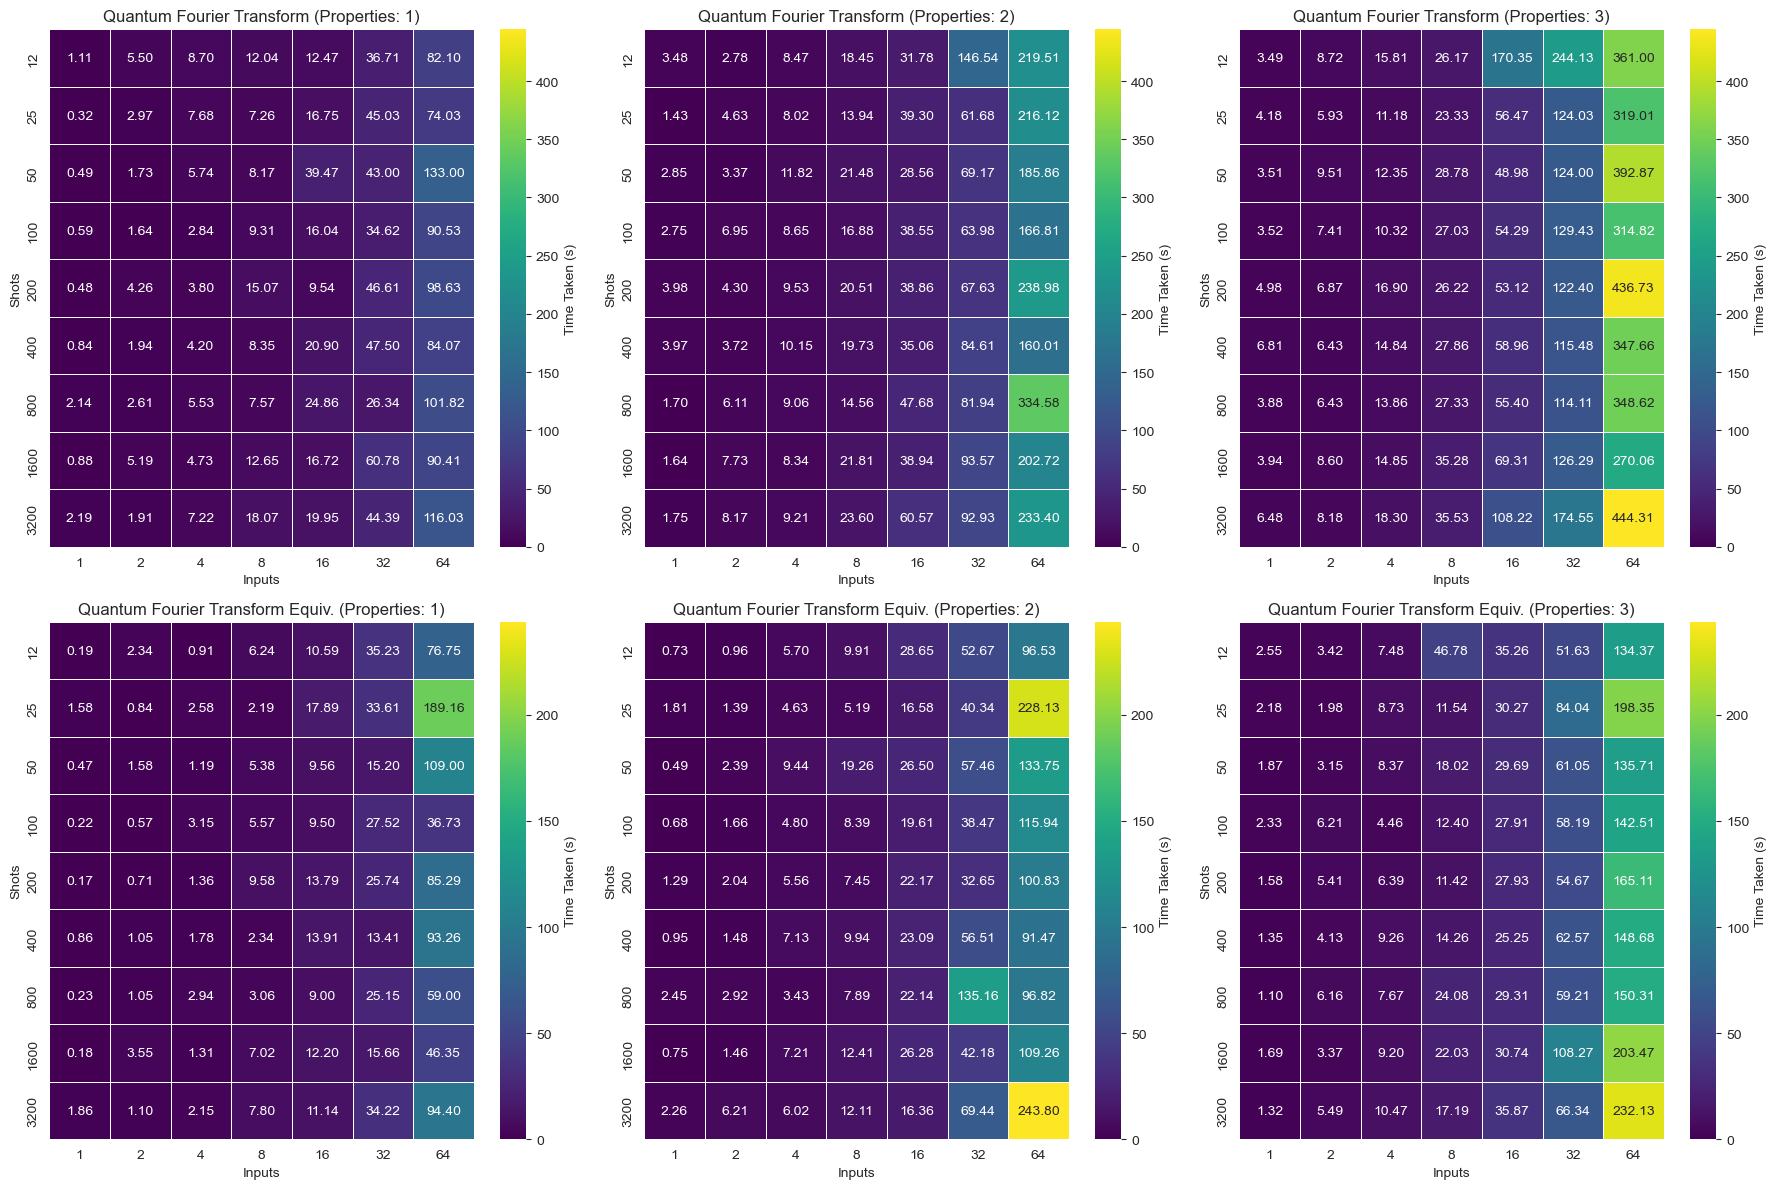

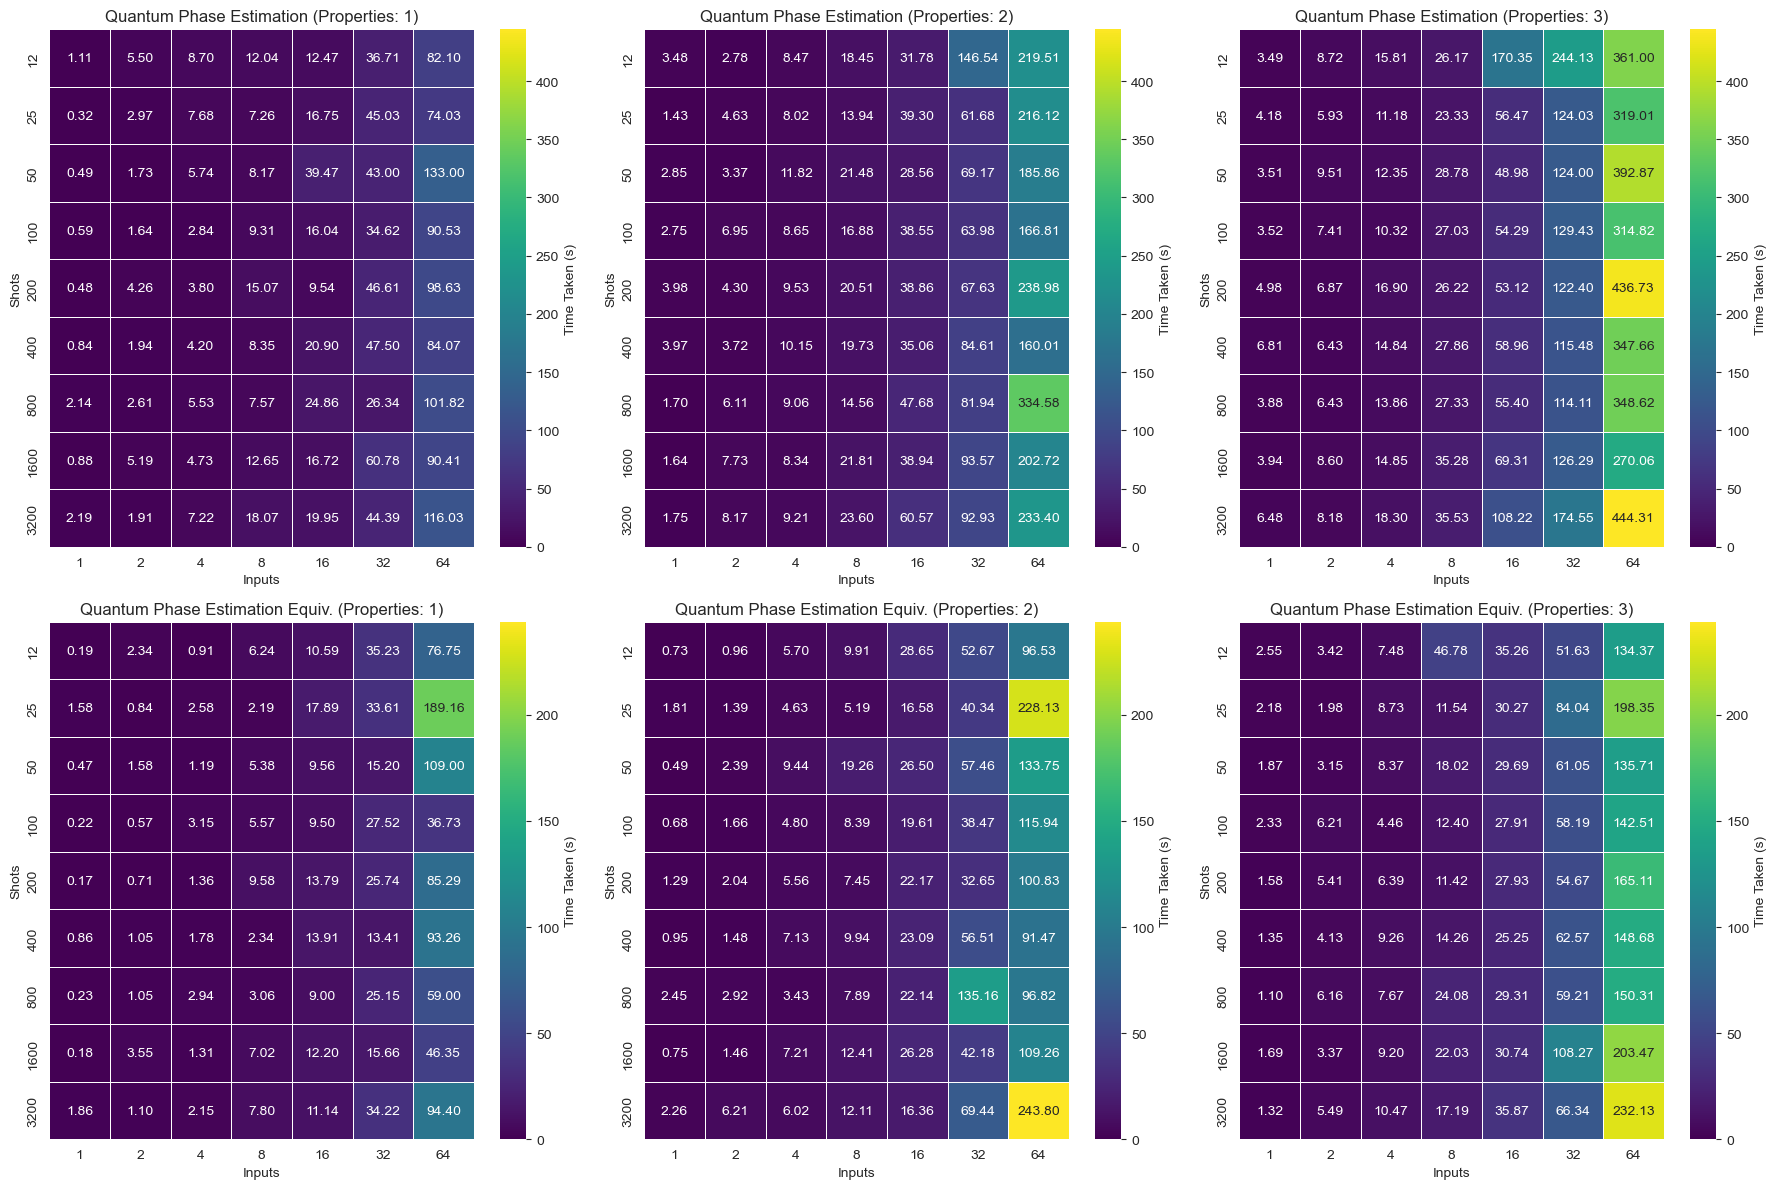

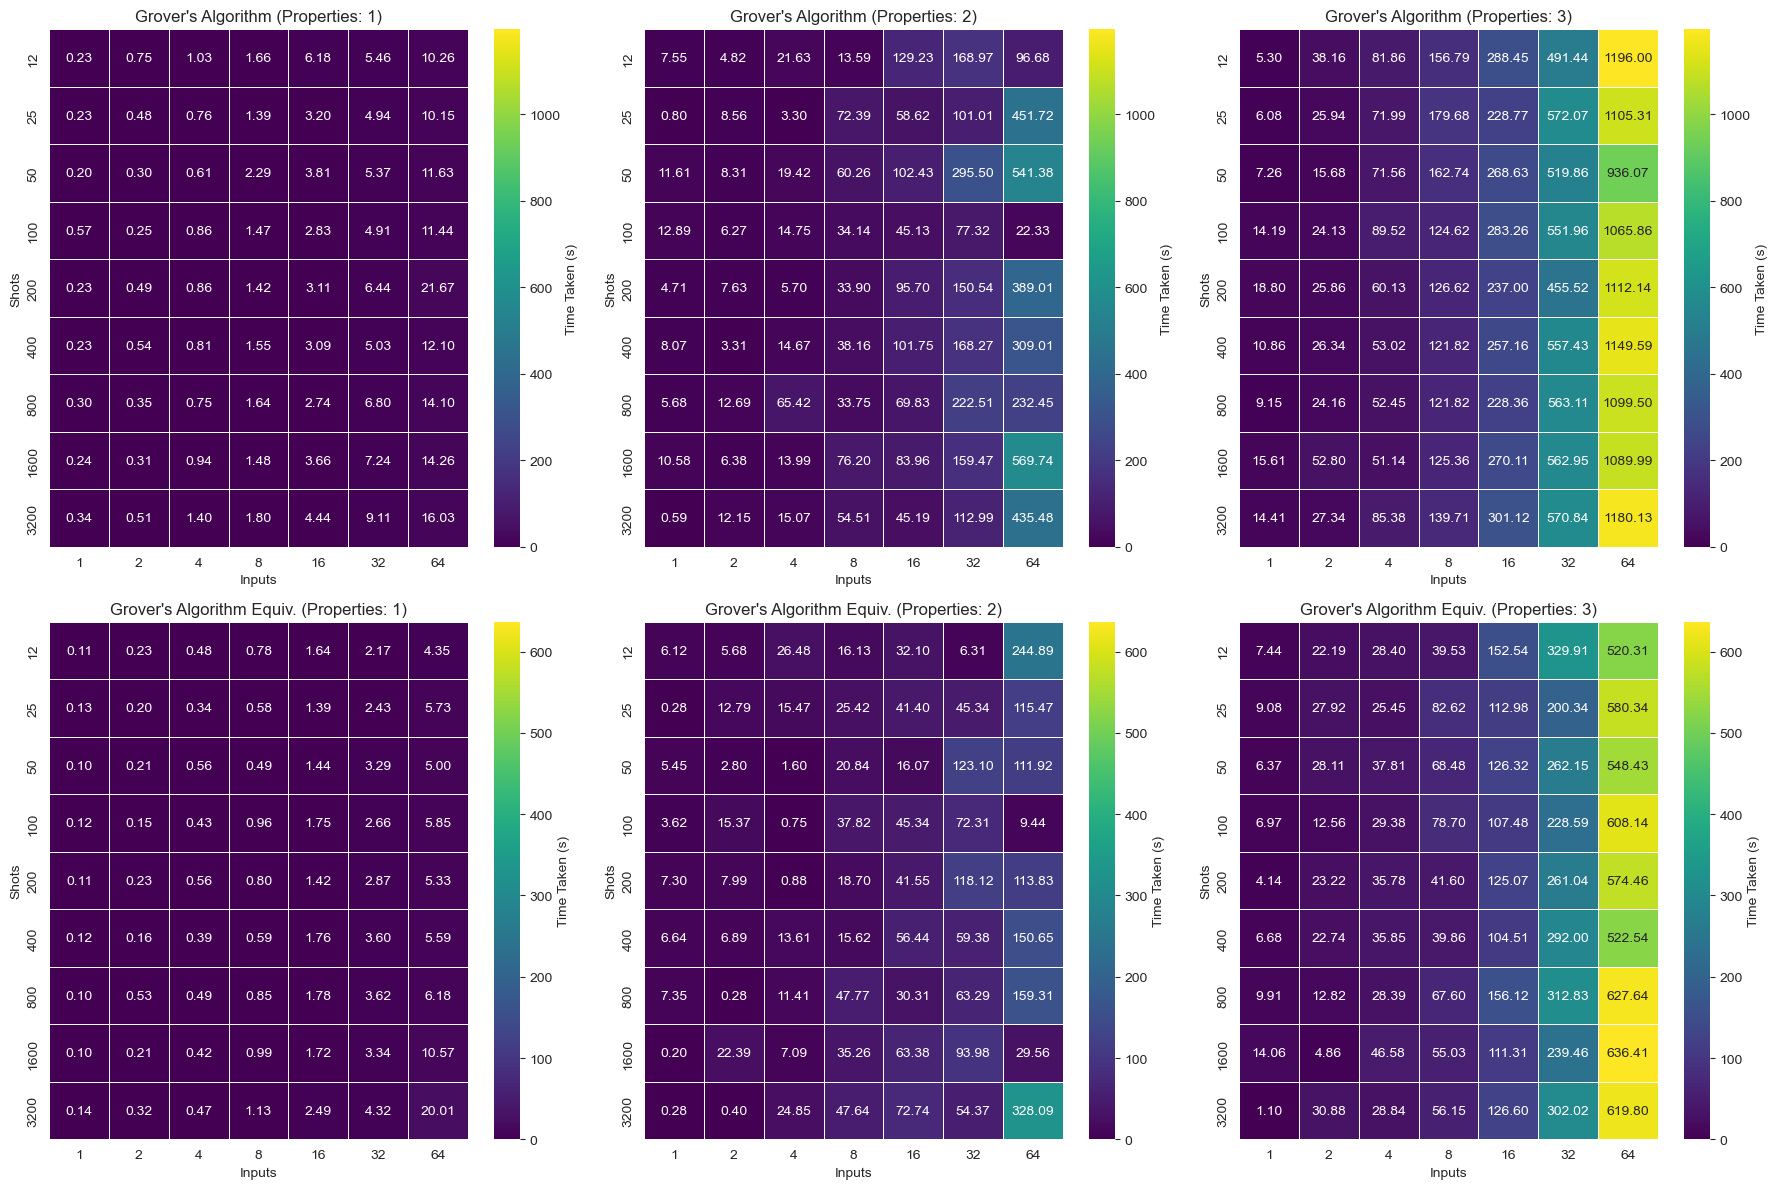

In [20]:
def plot_time_taken(df, algorithm_name):
    df_non_equivalent = df[df['Mutant Name'].str.contains('_m')]
    df_equivalent = df[df['Mutant Name'].str.contains('_em')]
    
    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # viridis or magma
    palette = sns.color_palette("viridis", as_cmap=True)

    sum_non_equiv_times = []
    # store the max sum time taken non equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        # get the largest value from the unstacked dataframe
        largest_value = failure_rate.max().max()
        sum_non_equiv_times.append(largest_value)
    max_time_non_equiv = max(sum_non_equiv_times)
        
    sum_equiv_times = []
    # store the max sum time taken equivalent
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        largest_value = failure_rate.max().max()
        sum_equiv_times.append(largest_value)
    max_time_equiv = max(sum_equiv_times)
        

    # Plot heatmaps for non-equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_non_equivalent[df_non_equivalent['Number of Properties'] == num_properties]
        failure_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(failure_rate, annot=True, cmap=palette, ax=axes[0, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_non_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[0, i].set_title(f'{algorithm_name} (Properties: {num_properties})')
        axes[0, i].set_xlabel('Inputs')
        axes[0, i].set_ylabel('Shots')

    # Plot heatmaps for equivalent mutants
    for i, num_properties in enumerate([1, 2, 3]):
        df_subset = df_equivalent[df_equivalent['Number of Properties'] == num_properties]
        pass_rate = df_subset.groupby(["Number of Measurements", "Number of Inputs"])['Time Taken'].apply(lambda x: x.sum()).unstack()
        
        sns.heatmap(pass_rate, annot=True, cmap=palette, ax=axes[1, i], fmt='.2f', 
                    linewidth=0.5, vmin=0, vmax=max_time_equiv, cbar_kws={'label': 'Time Taken (s)'}, 
                    annot_kws={"size": 10})
        axes[1, i].set_title(f'{algorithm_name} Equiv. (Properties: {num_properties})')
        axes[1, i].set_xlabel('Inputs')
        axes[1, i].set_ylabel('Shots')

    plt.tight_layout()
    plt.savefig(f"{algorithm_name.replace(' ', '_')}_time_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

plot_time_taken(qt_df, "Quantum Teleportation")
plot_time_taken(dj_df, "Deutsch-Jozsa")
plot_time_taken(qft_df, "Quantum Fourier Transform")
plot_time_taken(qft_df, "Quantum Phase Estimation")
plot_time_taken(grover_df, "Grover's Algorithm")

In [3]:
def read_merged_data_to_dataframe(algorithm_name, csv_filename):
    # Define the directory where the CSV files are stored
    filename = f"mutation_test_results/{algorithm_name}/{csv_filename}.csv"
    return pd.read_csv(filename)

qs_qt_df = read_merged_data_to_dataframe("quantum_teleportation", "QTQS_in_out")
sd_df = read_merged_data_to_dataframe("superdense_coding", "SDQS_correct_bits")

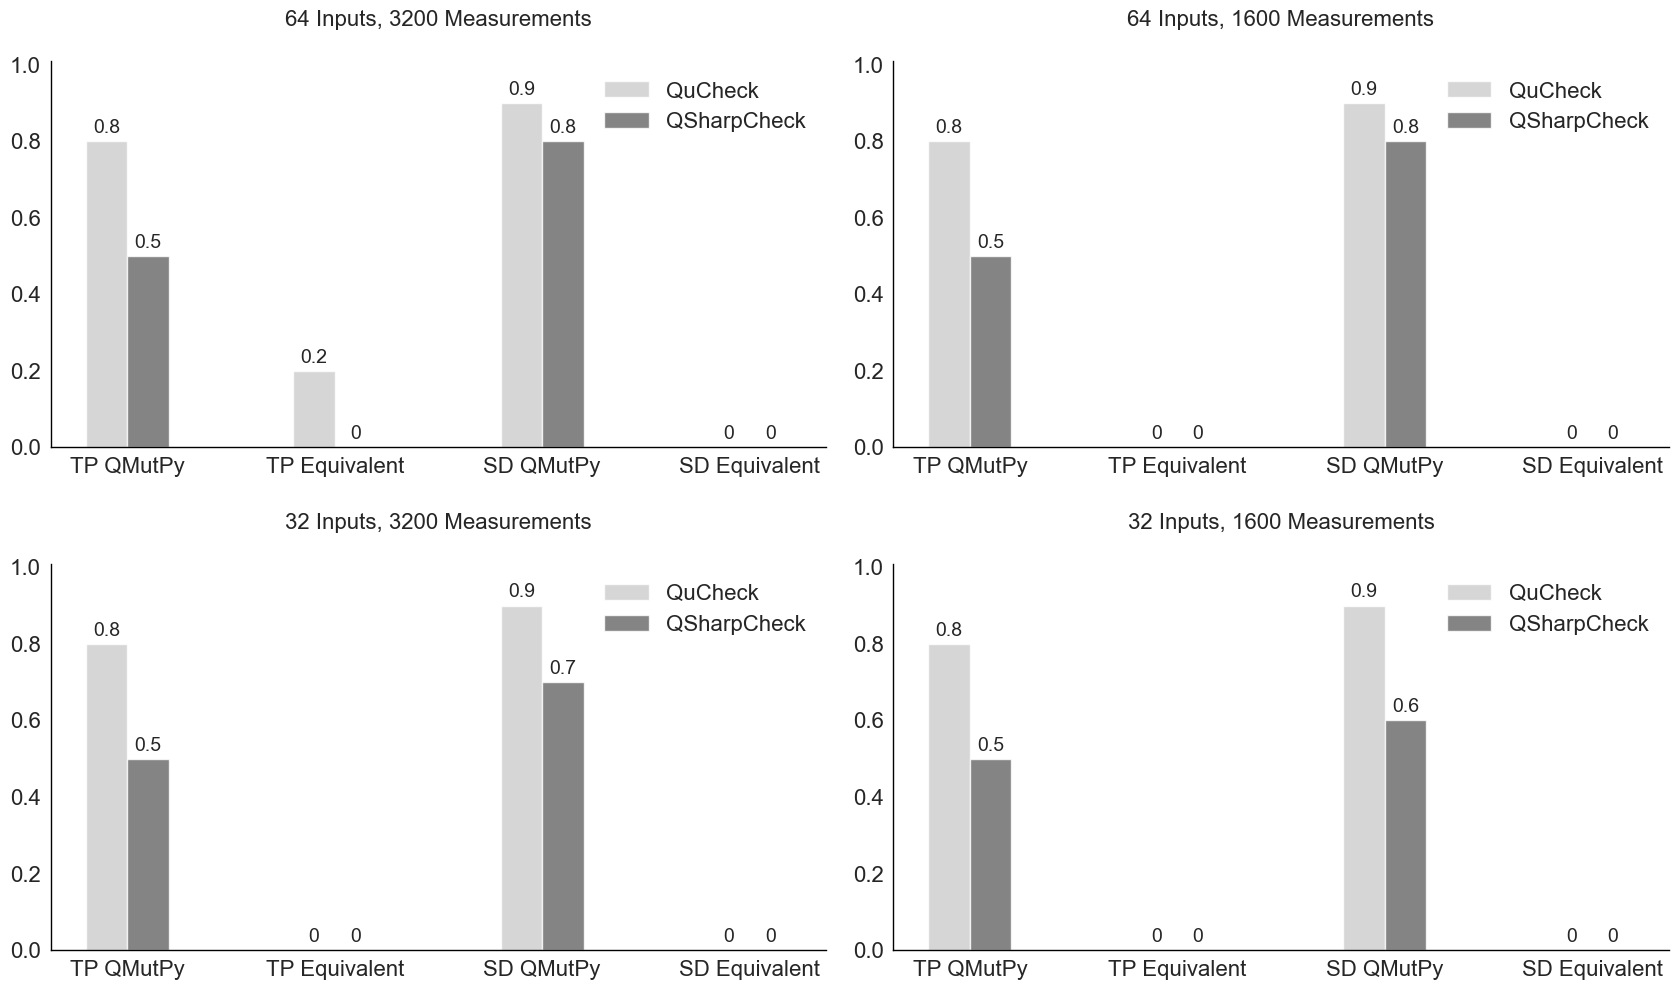

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, qs_sd_df, sd_df, feature_str):
    # Define configurations
    configs = [
        {'measurements': 3200, 'inputs': 64},
        {'measurements': 1600, 'inputs': 64},
        {'measurements': 3200, 'inputs': 32},
        {'measurements': 1600, 'inputs': 32}
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(17, 10))
    # fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)
    
    for idx, config in enumerate(configs):
        ax = axes[idx // 2, idx % 2]
        
        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == config['measurements']) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]
        
        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == config['measurements']) &
            (qt_df['Number of Inputs'] == config['inputs'])
        ]
        
        qs_sd_df_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == config['measurements']) &
            (qs_sd_df['Number of Inputs'] == config['inputs'])
        ]
        
        sd_df_filtered = sd_df[
            (sd_df['Number of Measurements'] == config['measurements']) &
            (sd_df['Number of Inputs'] == config['inputs'])
        ]
                
        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').mean()
        
        qs_sd_df_non_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures = (qs_sd_df_non_equivalent["Result"] == 'Fail').mean()
            
        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').mean()
        
        qs_sd_df_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures = (qs_sd_df_equivalent["Result"] == 'Fail').mean()
        
        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').mean()
        
        sd_df_non_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_m')]
        sd_non_equiv_failures = (sd_df_non_equivalent[feature_str] == 'Fail').mean()
        
        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').mean()
        
        sd_df_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_em')]
        sd_equiv_failures = (sd_df_equivalent[feature_str] == 'Fail').mean()
        
        # Prepare data for plotting
        algorithms = ["TP QMutPy", "TP Equivalent", "SD QMutPy", "SD Equivalent"]
        qiskit_results = np.array([qt_non_equiv_failures, qt_equiv_failures, sd_non_equiv_failures, sd_equiv_failures])
        qs_results = np.array([qs_non_equiv_failures, qs_equiv_failures, qs_sd_non_equiv_failures, qs_sd_equiv_failures])
        
        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.2
        
        grays = ["#CCCCCC", "#666666"]    
        
        rects1 = ax.bar(x - width/2, qiskit_results, width, color=grays[0], label='QuCheck', alpha=0.8)
        rects2 = ax.bar(x + width/2, qs_results, width, color=grays[1], label='QSharpCheck', alpha=0.8)
        
        ax.set_title(f'{config["inputs"]} Inputs, {config["measurements"]} Measurements', fontsize=16, pad=25)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)
        ax.legend()
        
        ax.bar_label(rects1, padding=3, fontsize=14)
        ax.bar_label(rects2, padding=3, fontsize=14)
        
        for item in ax.get_xticklabels() + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)
    
        ax.set(ylabel=None)
        ax.spines['left'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False, fontsize=16)
        
        
        ax.set_ylim(0, 1.01)
        ax.grid(False)
    
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    # plt.savefig(f"quantitative_comparison_configs.svg", dpi=100, bbox_inches='tight')
    plt.savefig(f"quantitative_comparison_configs.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df3 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
df4 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, df3, df4, "Result")

In [24]:
def split_and_group_dfs(dfs):
    grp_and_split_dfs = []
    for algorithm_df in dfs:
            df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
            df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]
    
            failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
            pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()).reset_index(name='Result')
            
            grp_and_split_dfs.append((failure_rate, pass_rate))
    return grp_and_split_dfs

In [25]:
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]    
dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
split_grouped_dfs = split_and_group_dfs(dfs)

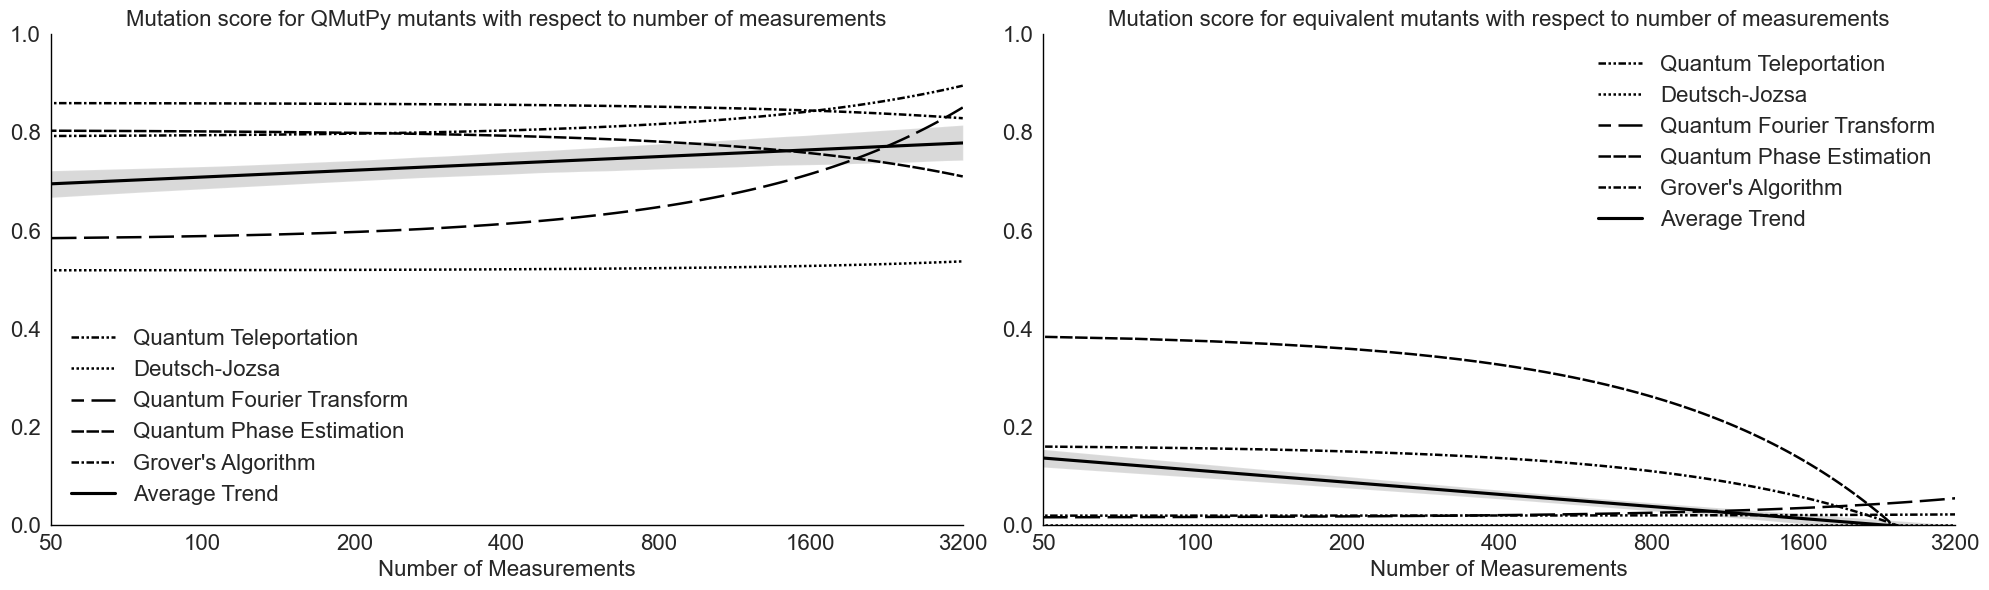

In [29]:
import matplotlib

def plot_failures(dfs, dfs_names, feature_str, log_scale=False, trendline=True):
    # Create a figure with 2 rows and 3 columns
    dash_styles = [
        (0, (3, 1, 1, 1, 1, 1)),       # solid line
        (0, (1, 1)),             # dashed line
        (5, (10, 3)),      # dash-dot line
        (0, (5, 1)),             # dotted line
        (0, (3, 1, 1, 1))      # dash-dot-dot line
    ]
    
    fig, ((ax1), (ax2)) = plt.subplots(1, 2, figsize=(20, 6))
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.title.set_text(f'Mutation score for QMutPy mutants with respect to {feature_str.lower()}')
    ax1.title.set_fontsize(16)
    ax2.title.set_text(f'Mutation score for equivalent mutants with respect to {feature_str.lower()}')
    ax2.title.set_fontsize(16)
    
    if log_scale:
        ax1.set_xscale('log')
        ax2.set_xscale('log')
    
    if feature_str == "Number of Measurements":
        ticks = [50, 100, 200, 400, 800, 1600, 3200]
    elif feature_str == "Number of Inputs":
        ticks = [1, 2, 4, 8, 16, 32, 64]
    elif feature_str == "Number of Properties":
        ticks = [1, 2, 3]
        
    ax1.set_xlim(ticks[0], ticks[-1])
    
    ax1.set_xticks(ticks)
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.minorticks_off()
    
    ax2.set_xlim(ticks[0], ticks[-1])
    ax2.set_xticks(ticks)
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.minorticks_off()

    idx = 0
    for algorithm_df, algorithm_name in zip(dfs, dfs_names):
        df_non_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_m')]
        df_equivalent = algorithm_df[algorithm_df['Mutant Name'].str.contains('_em')]

        failure_rate = df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/10.0).reset_index(name='Result')
        # sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar="sd", err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=2, color="red", dashes="dotted")
        # sns.lineplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name, linewidth=1.8, color="black", dashes=dash_styles[idx])
        sns.regplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label=algorithm_name, ci=None, color="black", scatter=False, line_kws={'linewidth': 1.8, 'linestyle': dash_styles[idx]})
        
        pass_rate = df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/5.0).reset_index(name='Result')
        # sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar="sd", err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=2, color="red", dashes="dotted")
        # sns.lineplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", errorbar=None, err_style="bars", err_kws={'capsize':10}, label=algorithm_name,linewidth=1.8, color="black", dashes=dash_styles[idx])
        sns.regplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label=algorithm_name, ci=None, color="black", scatter=False, line_kws={'linewidth': 1.8, 'linestyle': dash_styles[idx]})
        idx += 1
    
    if trendline:
        all_df = pd.concat(dfs)
        all_df_non_equivalent = all_df[all_df['Mutant Name'].str.contains('_m')]
        all_df_equivalent = all_df[all_df['Mutant Name'].str.contains('_em')]
        
        failure_rate = all_df_non_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/50.0).reset_index(name='Result')
        sns.regplot(ax=ax1, data=failure_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="black", logx=log_scale, ci=95)
        
        pass_rate = all_df_equivalent.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties"])['Result'].apply(lambda x: (x == 'Fail').sum()/25.0).reset_index(name='Result')
        sns.regplot(ax=ax2, data=pass_rate, x=feature_str, y="Result", label="Average Trend", scatter=False, color="black", logx=log_scale, ci=95)
    

    ax1.set(ylabel=None)
    ax1.xaxis.label.set_size(16)
    ax2.xaxis.label.set_size(16)
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('black')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('black')
    ax1.axvline(color='k', linewidth=1)
    ax2.set(ylabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('black')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('black')
    ax1.legend(frameon=False, fontsize=16)
    ax2.legend(frameon=False, fontsize=16)
    sns.despine()
    
    plt.tight_layout()
    plt.savefig(f"{feature_str.replace(' ', '_')}_failures_line.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close()

dfs = [qt_df, dj_df, qft_df, qpe_df, grover_df]
dfs_names = ["Quantum Teleportation", "Deutsch-Jozsa", "Quantum Fourier Transform", "Quantum Phase Estimation", "Grover's Algorithm"]


plot_failures(dfs, dfs_names, "Number of Measurements", log_scale=True)

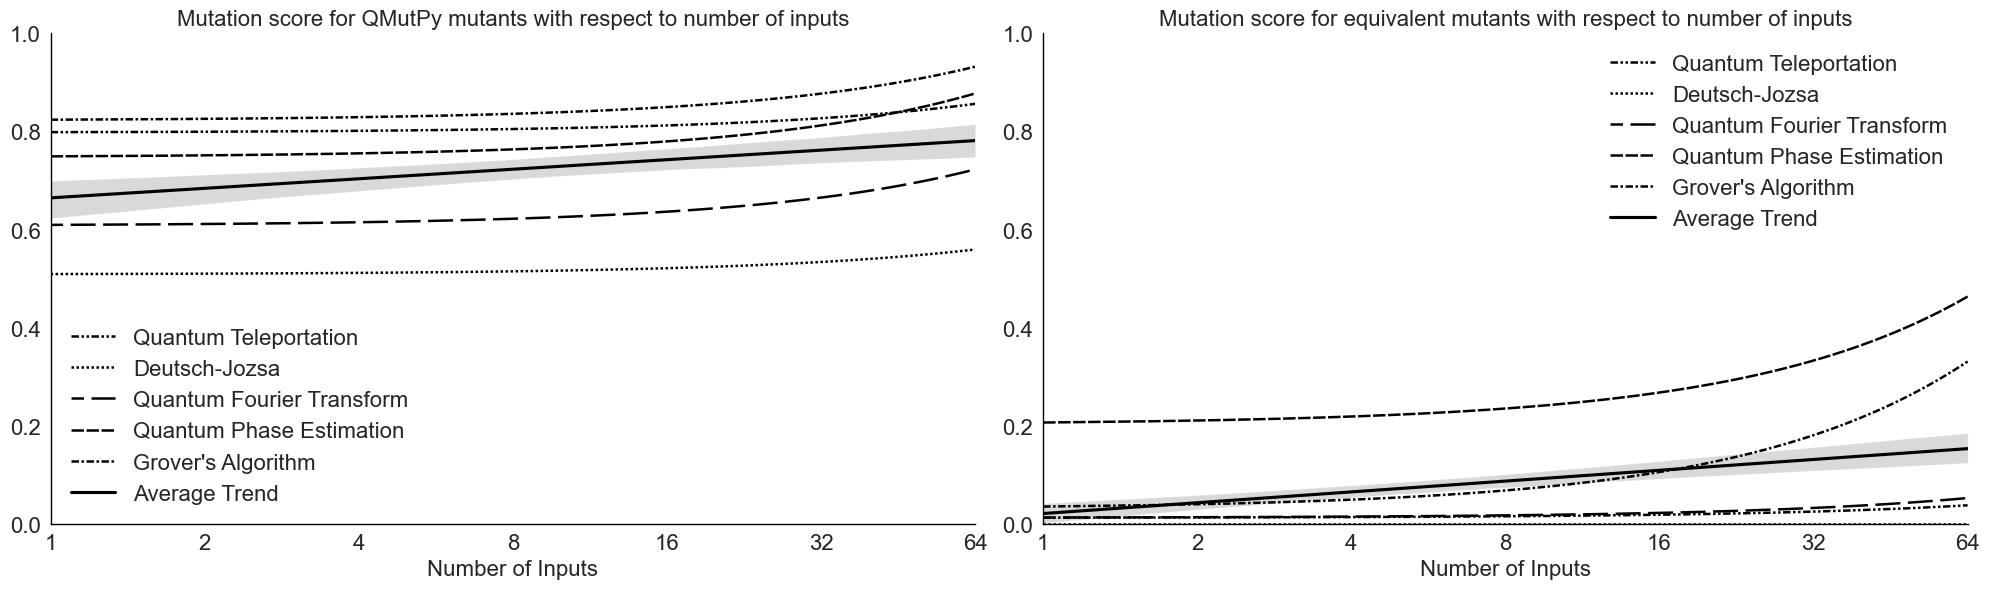

In [30]:
plot_failures(dfs, dfs_names, "Number of Inputs", log_scale=True)

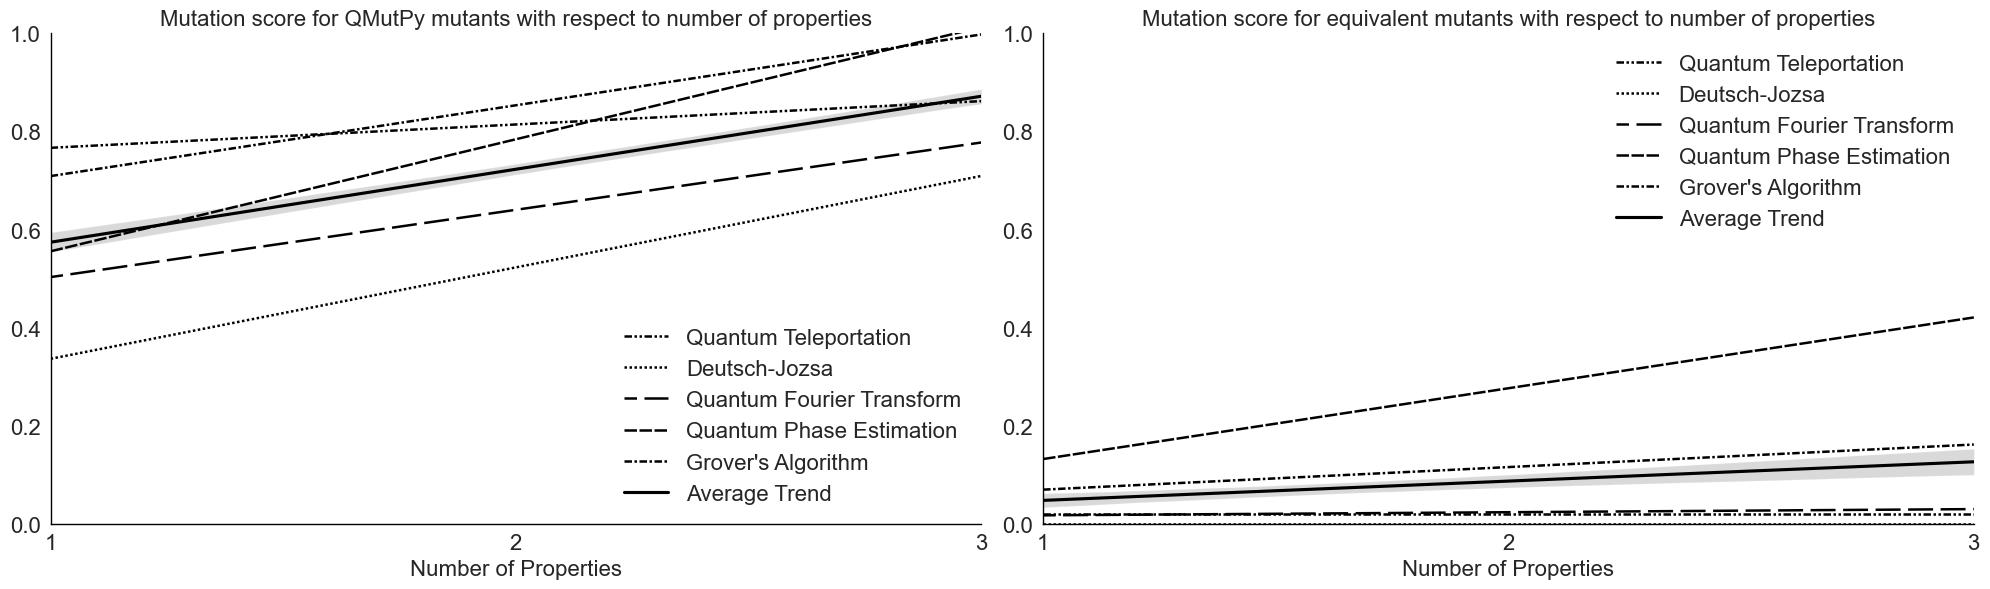

In [31]:
plot_failures(dfs, dfs_names, "Number of Properties", log_scale=False)

In [6]:
# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_stats_(df, group_by="Number of Properties", filter_by_feature=None, filter_by_values=None):
    failure_rate = df[df['Equivalent'] == False]
    pass_rate = df[df['Equivalent'] == True]
    
    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            failure_rate = failure_rate[failure_rate[filter_by_feature[i]].isin(filter_by_values[i])]
            pass_rate = pass_rate[pass_rate[filter_by_feature[i]].isin(filter_by_values[i])]
        
    print("Not Equivalent")
    
    if group_by is not None:
        print("STD NE")
        print(failure_rate.groupby(group_by)['Result'].std())
        print("Median NE")
        print(failure_rate.groupby(group_by)['Result'].median())
        print("Mean NE")
        print(failure_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient NE")
        print(scipy.stats.spearmanr(failure_rate[group_by], failure_rate["Result"], alternative='two-sided'))
    else:
        print("STD NE")
        print(failure_rate['Result'].std())
        print("Median NE")
        print(failure_rate['Result'].median())
        print("Mean NE")
        print(failure_rate['Result'].mean())
    
    print("Equivalent")
    
    if group_by is not None:
        print("STD E")
        print(pass_rate.groupby(group_by)['Result'].std())
        print("Median E")
        print(pass_rate.groupby(group_by)['Result'].median())
        print("Mean E")
        print(pass_rate.groupby(group_by)['Result'].mean())
        print("Pearson Correlation Coefficient E")
        print(scipy.stats.spearmanr(pass_rate[group_by], pass_rate["Result"], alternative='two-sided'))
    else:
        print("STD E")
        print(pass_rate['Result'].std())
        print("Median E")
        print(pass_rate['Result'].median())
        print("Mean E")
        print(pass_rate['Result'].mean())

get_stats(all_df_c, group_by="Number of Properties")

Not Equivalent
STD NE
Number of Properties
1    0.223334
2    0.202358
3    0.156862
Name: Result, dtype: float64
Median NE
Number of Properties
1    0.6
2    0.8
3    0.9
Name: Result, dtype: float64
Mean NE
Number of Properties
1    0.554286
2    0.762540
3    0.852063
Name: Result, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.5323913674589874, pvalue=2.745390619365338e-70)
Equivalent
STD E
Number of Properties
1    0.116447
2    0.216024
3    0.282058
Name: Result, dtype: float64
Median E
Number of Properties
1    0.0
2    0.0
3    0.0
Name: Result, dtype: float64
Mean E
Number of Properties
1    0.044444
2    0.092698
3    0.123175
Name: Result, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.0765986920579574, pvalue=0.018520053560462706)


C:\Users\gabri\AppData\Local\Temp\ipykernel_23948\2868043527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c1df["Group"] = "1600 Measurements, 32 Inputs"
C:\Users\gabri\AppData\Local\Temp\ipykernel_23948\2868043527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c2df["Group"] = "1600 Measurements, 64 Inputs"
C:\Users\gabri\AppData\Local\Temp\ipykernel_23948\2868043527.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

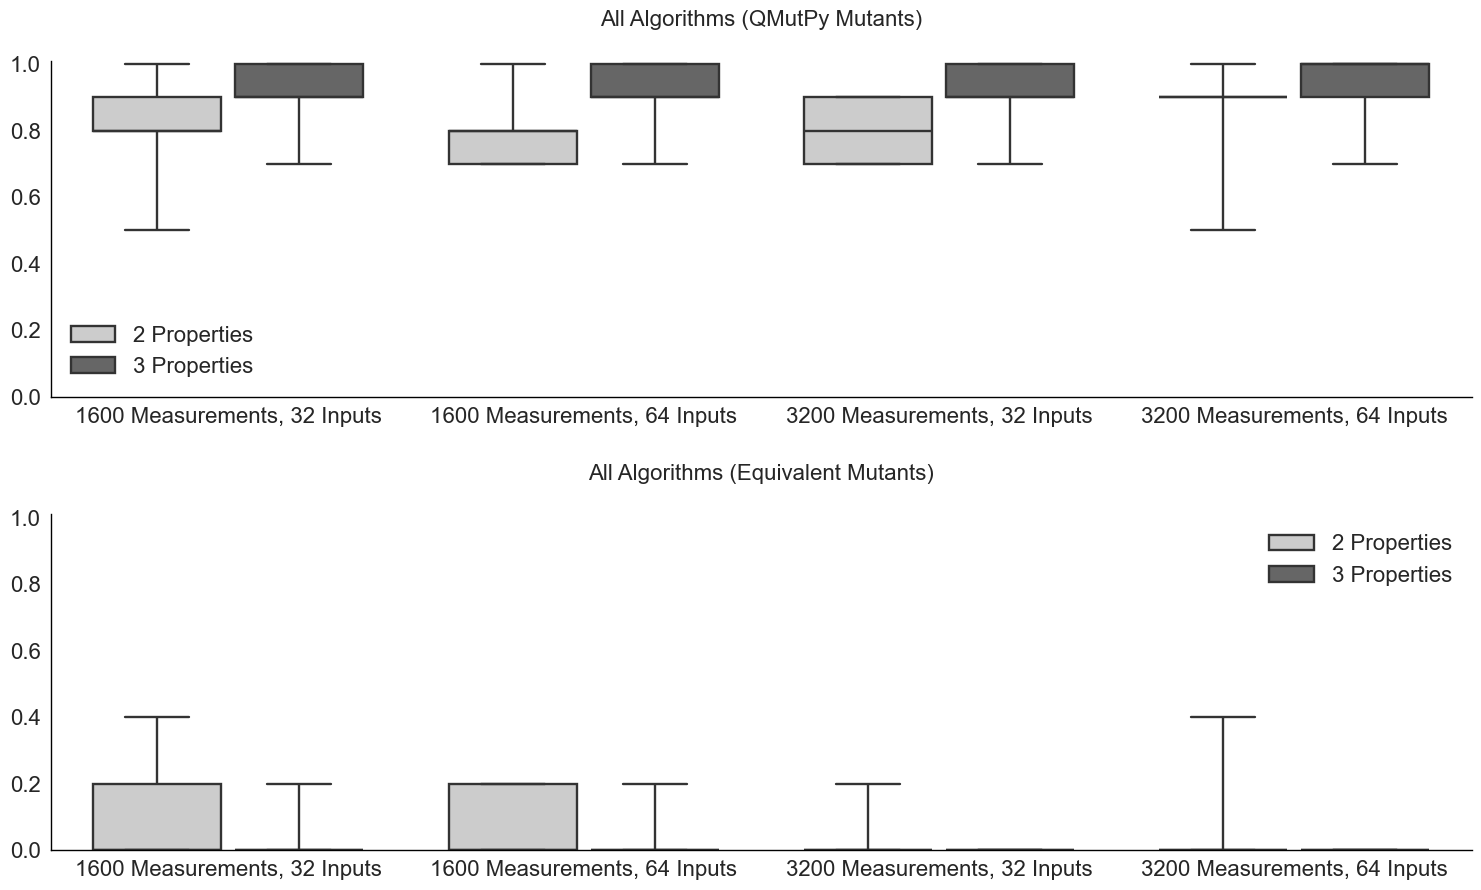

In [9]:
def plot_boxplot(df):    
    c1df = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 2) & (df["Equivalent"] == False)]
    c1df["Group"] = "1600 Measurements, 32 Inputs"
    c2df = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 2) & (df["Equivalent"] == False)]
    c2df["Group"] = "1600 Measurements, 64 Inputs"
    c3df = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 2) & (df["Equivalent"] == False)]
    c3df["Group"] = "3200 Measurements, 32 Inputs"
    c4df = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 2) & (df["Equivalent"] == False)]
    c4df["Group"] = "3200 Measurements, 64 Inputs"
    c5df = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 3) & (df["Equivalent"] == False)]
    c5df["Group"] = "1600 Measurements, 32 Inputs"
    c6df = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 3) & (df["Equivalent"] == False)]
    c6df["Group"] = "1600 Measurements, 64 Inputs"
    c7df = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 3) & (df["Equivalent"] == False)]
    c7df["Group"] = "3200 Measurements, 32 Inputs"
    c8df = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 3) & (df["Equivalent"] == False)]
    c8df["Group"] = "3200 Measurements, 64 Inputs"
    
    
    c1dfe = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 2) & (df["Equivalent"] == True)]
    c1dfe["Group"] = "1600 Measurements, 32 Inputs"
    c2dfe = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 2) & (df["Equivalent"] == True)]
    c2dfe["Group"] = "1600 Measurements, 64 Inputs"
    c3dfe = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 2) & (df["Equivalent"] == True)]
    c3dfe["Group"] = "3200 Measurements, 32 Inputs"
    c4dfe = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 2) & (df["Equivalent"] == True)]
    c4dfe["Group"] = "3200 Measurements, 64 Inputs"
    c5dfe = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 3) & (df["Equivalent"] == True)]
    c5dfe["Group"] = "1600 Measurements, 32 Inputs"
    c6dfe = df[(df["Number of Measurements"] == 1600) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 3) & (df["Equivalent"] == True)]
    c6dfe["Group"] = "1600 Measurements, 64 Inputs"
    c7dfe = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 32) & (df["Number of Properties"] == 3) & (df["Equivalent"] == True)]
    c7dfe["Group"] = "3200 Measurements, 32 Inputs"
    c8dfe = df[(df["Number of Measurements"] == 3200) & (df["Number of Inputs"] == 64) & (df["Number of Properties"] == 3) & (df["Equivalent"] == True)]
    c8dfe["Group"] = "3200 Measurements, 64 Inputs"

    # Concatenate the dataframes for plotting
    df_concat = pd.concat([c1df, c2df, c3df, c4df, c5df, c6df, c7df, c8df])
    df_concat_equiv = pd.concat([c1dfe, c2dfe, c3dfe, c4dfe, c5dfe, c6dfe, c7dfe, c8dfe])

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 9))

    # light gray, and dark gray colours in seaborn palette
    grays = ["#CCCCCC", "#666666"]    
    
    sns.boxplot(ax=ax1, x="Group", y="Result", data=df_concat, linewidth=1.7, fill=True, hue="Number of Properties", linecolor="#333333", palette=grays, whis=(0, 100), gap=.1)
    sns.boxplot(ax=ax2, x="Group", y="Result", data=df_concat_equiv, linewidth=1.7, fill=True, hue="Number of Properties", linecolor="#333333", palette=grays, whis=(0, 100), gap=.1)
    
    ax1.set_ylim(0, 1.01)
    ax2.set_ylim(0, 1.01)
    
    ax1.grid(False)
    ax2.grid(False)
    
    ax1.legend(frameon=False, fontsize=16)
    ax1.legend_.texts[0].set_text("2 Properties")
    ax1.legend_.texts[1].set_text("3 Properties")
    ax2.legend(frameon=False, fontsize=16)
    ax2.legend_.texts[0].set_text("2 Properties")
    ax2.legend_.texts[1].set_text("3 Properties")
    
    ax1.set_title(f'All Algorithms (QMutPy Mutants)', fontsize=16, pad=25)
    ax2.set_title(f'All Algorithms (Equivalent Mutants)', fontsize=16, pad=25)
    
    # ax1.title.set_text(f'Mutation score for QMutPy mutants with "strong" configurations')
    # ax1.title.set_fontsize(16)
    # ax1.title.(20)
    # ax2.title.set_text(f'Mutation score for equivalent mutants with "strong" configurations')
    # ax2.title.set_fontsize(16)
    # ax2.title.set_pad(20)
    
    for item in ax1.get_xticklabels() + ax2.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        item.set_fontsize(16)
    
    ax1.set(ylabel=None, xlabel=None)
    ax1.spines['left'].set_linewidth(1)
    ax1.spines['left'].set_color('k')
    ax1.spines['bottom'].set_linewidth(1)
    ax1.spines['bottom'].set_color('k')
    ax2.set(ylabel=None, xlabel=None)
    ax2.spines['left'].set_linewidth(1)
    ax2.spines['left'].set_color('k')
    ax2.spines['bottom'].set_linewidth(1)
    ax2.spines['bottom'].set_color('k')
    
    sns.despine()
    
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.35)
    # plt.savefig(f"boxplot_configs.svg", dpi=100, bbox_inches='tight')
    plt.savefig(f"boxplot_configs.png", dpi=300, bbox_inches='tight')
    plt.show()
    
all_df_c = clean([all_df])
plot_boxplot(all_df_c)

In [10]:
def clean_and_add_time(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df2 = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Result'].apply(lambda x: (x == 'Fail').sum() / (5.0 if x.name[3] else 10.0)).reset_index()
        df3 = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])['Time Taken'].apply(lambda x: x.sum() / (5.0 if x.name[3] else 10.0)).reset_index()
        
        df = pd.merge(df2, df3, on=["Number of Measurements", "Number of Inputs", "Number of Properties", "Equivalent", "Algorithm"])
        return df
    
def clean_and_add_time_equiv_agnostic(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        df = df.groupby(["Number of Measurements", "Number of Inputs", "Number of Properties", "Algorithm"])['Time Taken'].apply(lambda x: x.sum() / 15.0).reset_index()
        return df    
    
# get the standard deviation of data for all algorithms from 1-3 properties and 50-3200 measurements, and 1-64 inputs
def get_time_stats(df, filter_by_feature=None, filter_by_values=None):
    res_df = df
    
    if filter_by_feature is not None:
        for i in range(len(filter_by_feature)):
            res_df = res_df[res_df[filter_by_feature[i]].isin(filter_by_values[i])]    

    print(res_df[['Algorithm', 'Time Taken']])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# all_df
all_df_c = clean_and_add_time_equiv_agnostic([all_df])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[3], [3200], [64]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[3], [1600], [64]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[3], [3200], [32]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[3], [1600], [32]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[2], [3200], [64]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[2], [1600], [64]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[2], [3200], [32]])
get_time_stats(all_df_c, filter_by_feature=['Number of Properties', 'Number of Measurements', "Number of Inputs"], filter_by_values=[[2], [1600], [32]])

                     Algorithm  Time Taken
940              deutsch_jozsa    3.664956
941          grovers_algorithm  119.995380
942  quantum_fourier_transform   45.096192
943   quantum_phase_estimation   49.050344
944      quantum_teleportation    6.706037
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                     Algorithm  Time Taken
835              deutsch_jozsa    3.141149
836          grovers_algorithm  115.093501
837  quantum_fourier_transform   31.568309
838   quantum_phase_estimation   43.182373
839      quantum_teleportation    4.927145
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                     Algorithm  Time Taken
925              deutsch_jozsa    1.856806
926          grovers_algorithm   58.190898
927  quantum_fourier_transform   16.059512
928   quantum_phase_estimation   26.286429
929      quantum_teleportation    3.452839
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                     Algorithm  Time Taken
820              deutsch_jozsa    1.593398
821          grovers_algorithm   53

In [83]:
all_df_c = clean_and_add_time([all_df])
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[3], [3200], [64]])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[3], [1600], [64]])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[3], [3200], [32]])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[3], [1600], [32]])

Not Equivalent
STD NE
0.130384048104053
Median NE
1.0
Mean NE
0.9199999999999999
Equivalent
STD E
0.0
Median E
0.0
Mean E
0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Not Equivalent
STD NE
0.12247448713915893
Median NE
0.9
Mean NE
0.9
Equivalent
STD E
0.08944271909999159
Median E
0.0
Mean E
0.04
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Not Equivalent
STD NE
0.12247448713915893
Median NE
0.9
Mean NE
0.9
Equivalent
STD E
0.0
Median E
0.0
Mean E
0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Not Equivalent
STD NE
0.12247448713915893
Median NE
0.9
Mean NE
0.9
Equivalent
STD E
0.08944271909999159
Median E
0.0
Mean E
0.04


In [7]:
all_df_c = clean_and_add_time([all_df])
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[2], [3200], [64]])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[2], [1600], [64]])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[2], [3200], [32]])
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
get_stats(all_df_c, group_by=None, filter_by_feature=['Number of Properties', 'Number of Measurements', 'Number of Inputs'], filter_by_values=[[2], [1600], [32]])

NameError: name 'all_df' is not defined

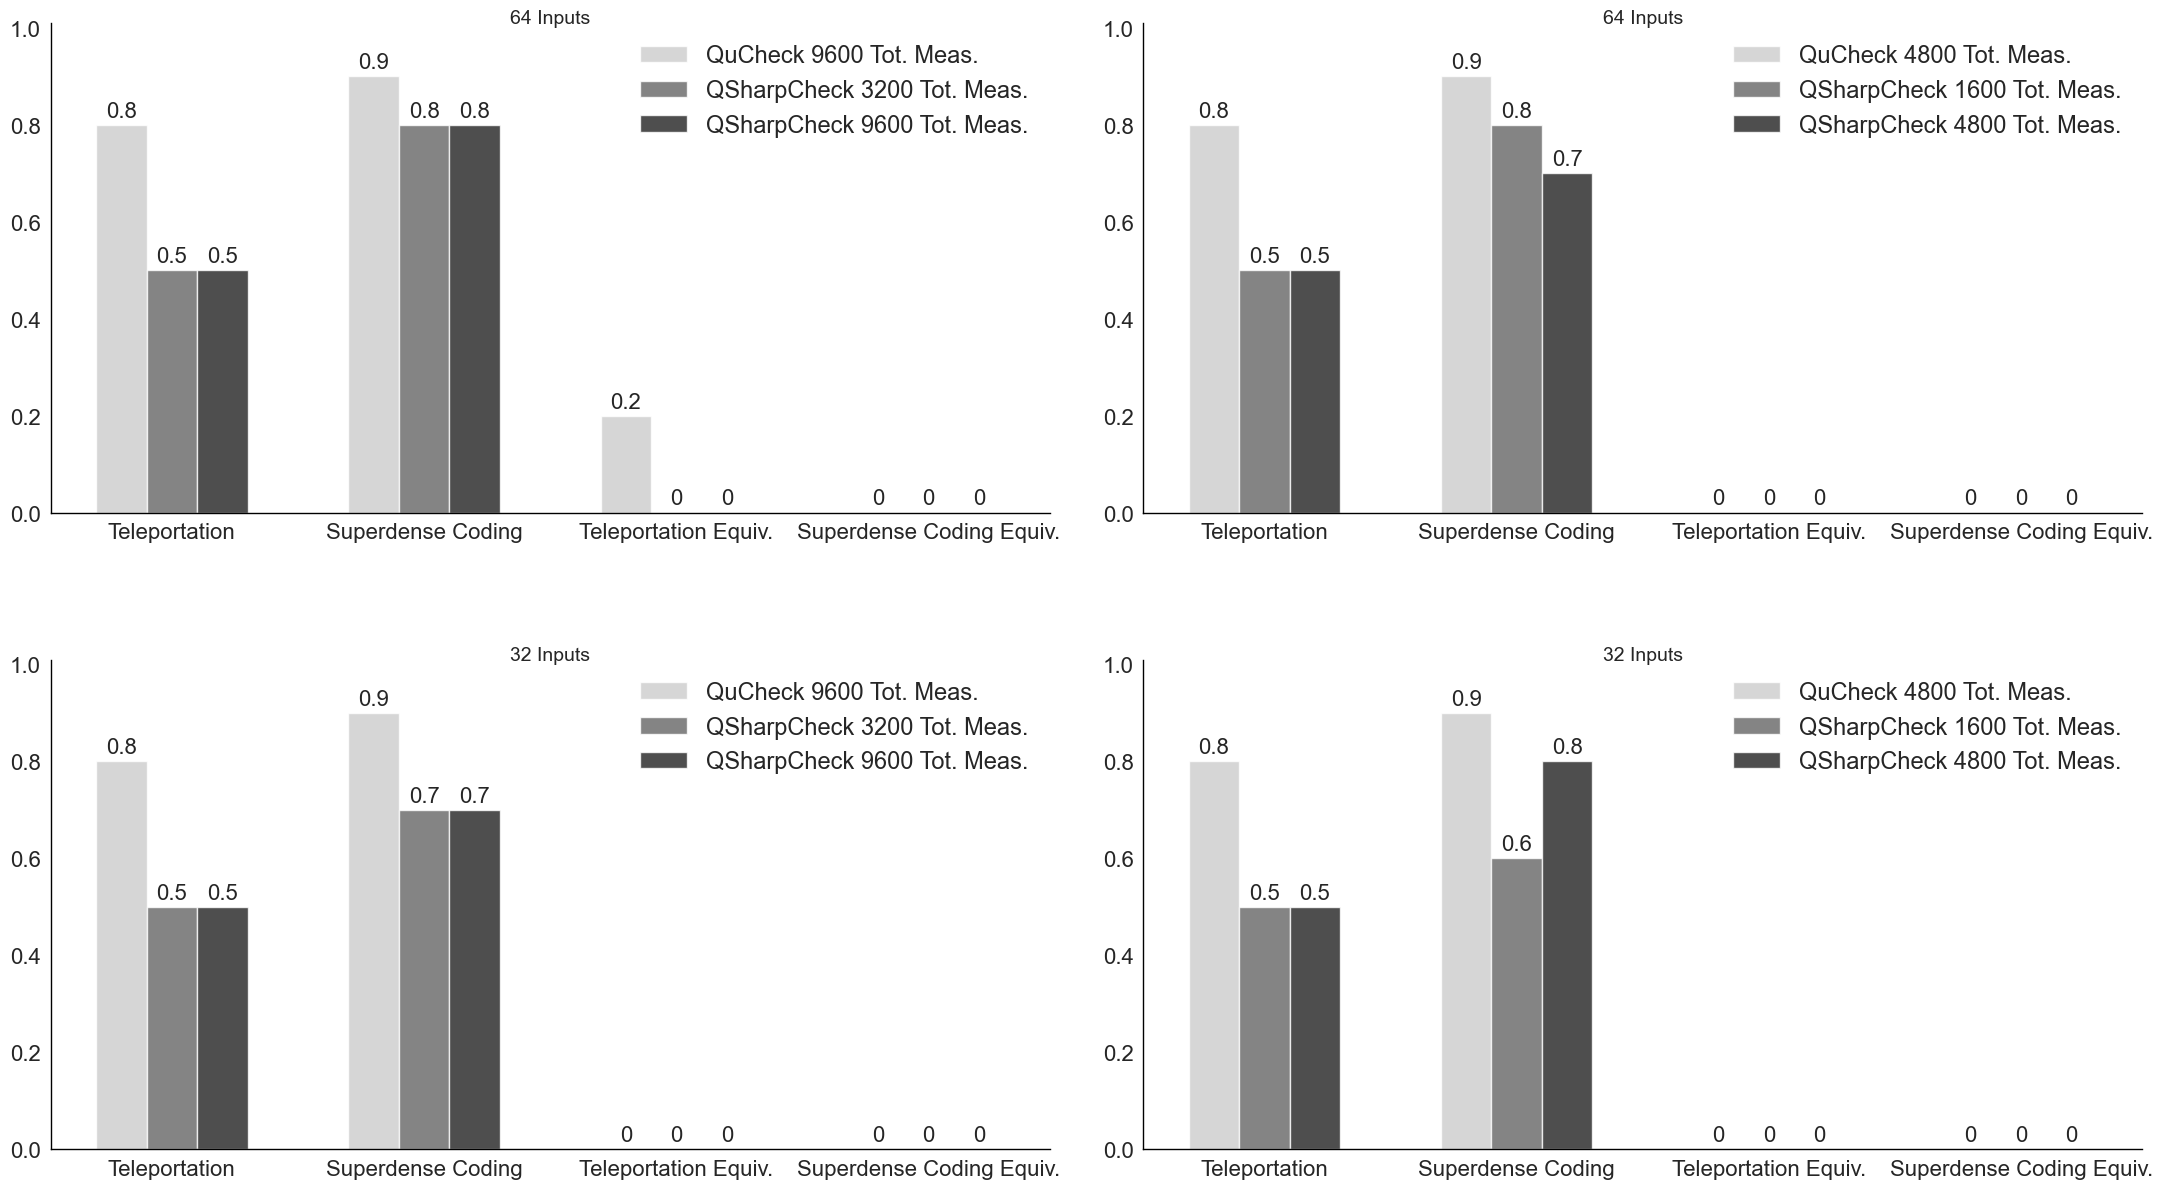

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, qs_sd_df, sd_df, feature_str):
    # Define configurations
    configs = [
        {'measurements': 3200, 'inputs': 64},
        {'measurements': 1600, 'inputs': 64},
        {'measurements': 3200, 'inputs': 32},
        {'measurements': 1600, 'inputs': 32}
    ]

    fig, axes = plt.subplots(2, 2, figsize=(22, 12))
    # fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)

    for idx, config in enumerate(configs):
        ax = axes[idx // 2, idx % 2]

        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == config['measurements']) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]

        qs_qt_df_long_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == (config['measurements']*3)) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]

        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == config['measurements']) &
            (qt_df['Number of Inputs'] == config['inputs'])
        ]

        qs_sd_df_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == config['measurements']) &
            (qs_sd_df['Number of Inputs'] == config['inputs'])
        ]

        qs_sd_df_long_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == (config['measurements']*3)) &
            (qs_sd_df['Number of Inputs'] == config['inputs'])
        ]

        sd_df_filtered = sd_df[
            (sd_df['Number of Measurements'] == config['measurements']) &
            (sd_df['Number of Inputs'] == config['inputs'])
        ]

        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = (qs_qt_df_non_equivalent["Result"] == 'Fail').mean()

        qs_sd_df_non_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures = (qs_sd_df_non_equivalent["Result"] == 'Fail').mean()

        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = (qs_qt_df_equivalent["Result"] == 'Fail').mean()

        qs_sd_df_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures = (qs_sd_df_equivalent["Result"] == 'Fail').mean()

        # Q# long results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent_long = qs_qt_df_long_filtered[qs_qt_df_long_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures_long = (qs_qt_df_non_equivalent_long["Result"] == 'Fail').mean()

        qs_sd_df_non_equivalent_long = qs_sd_df_long_filtered[qs_sd_df_long_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures_long = (qs_sd_df_non_equivalent_long["Result"] == 'Fail').mean()

        qs_qt_df_equivalent_long = qs_qt_df_long_filtered[qs_qt_df_long_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures_long = (qs_qt_df_equivalent_long["Result"] == 'Fail').mean()

        qs_sd_df_equivalent_long = qs_sd_df_long_filtered[qs_sd_df_long_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures_long = (qs_sd_df_equivalent_long["Result"] == 'Fail').mean()

        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = (qt_df_non_equivalent[feature_str] == 'Fail').mean()

        sd_df_non_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_m')]
        sd_non_equiv_failures = (sd_df_non_equivalent[feature_str] == 'Fail').mean()

        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = (qt_df_equivalent[feature_str] == 'Fail').mean()

        sd_df_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_em')]
        sd_equiv_failures = (sd_df_equivalent[feature_str] == 'Fail').mean()

        # Prepare data for plotting
        # algorithms = ["TP QMutPy", "TP Equivalent", "SD QMutPy", "SD Equivalent"]
        # qiskit_results = np.array([qt_non_equiv_failures, qt_equiv_failures, sd_non_equiv_failures, sd_equiv_failures])
        # qs_results = np.array([qs_non_equiv_failures, qs_equiv_failures, qs_sd_non_equiv_failures, qs_sd_equiv_failures])
        # qs_results_long = np.array([qs_non_equiv_failures_long, qs_equiv_failures_long, qs_sd_non_equiv_failures_long, qs_sd_equiv_failures_long])

        algorithms = ["Teleportation", "Superdense Coding", "Teleportation Equiv.", "Superdense Coding Equiv."]
        qiskit_results = np.array([qt_non_equiv_failures, sd_non_equiv_failures, qt_equiv_failures, sd_equiv_failures])
        qs_results = np.array([qs_non_equiv_failures, qs_sd_non_equiv_failures, qs_equiv_failures, qs_sd_equiv_failures])
        qs_results_long = np.array([qs_non_equiv_failures_long, qs_sd_non_equiv_failures_long, qs_equiv_failures_long, qs_sd_equiv_failures_long])


        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.2

        grays = ["#CCCCCC", "#666666", "#222222"]

        rects1 = ax.bar(x - width, qiskit_results, width, color=grays[0], label=f'QuCheck {config["measurements"]*3} Tot. Meas.', alpha=0.8)
        rects2 = ax.bar(x , qs_results, width, color=grays[1], label=f'QSharpCheck {config["measurements"]} Tot. Meas.', alpha=0.8)
        rects3 = ax.bar(x + width, qs_results_long, width, color=grays[2], label=f'QSharpCheck {config["measurements"]*3} Tot. Meas.', alpha=0.8)

        ax.set_title(f'{config["inputs"]} Inputs', fontsize=14, pad=0)
        # ax.set_title(f'{config["inputs"]} Inputs', fontsize=14, pad=25)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)

        ax.bar_label(rects1, padding=3, fontsize=16)
        ax.bar_label(rects2, padding=3, fontsize=16)
        ax.bar_label(rects3, padding=3, fontsize=16)

        for item in ax.get_xticklabels() + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

        ax.set(ylabel=None)
        ax.spines['left'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False, fontsize=17)


        ax.set_ylim(0, 1.01)
        ax.grid(False)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    # plt.savefig(f"quantitative_comparison_configs.svg", dpi=100, bbox_inches='tight')
    plt.savefig(f"quantitative_comparison_configs.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df3 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
df4 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, df3, df4, "Result")

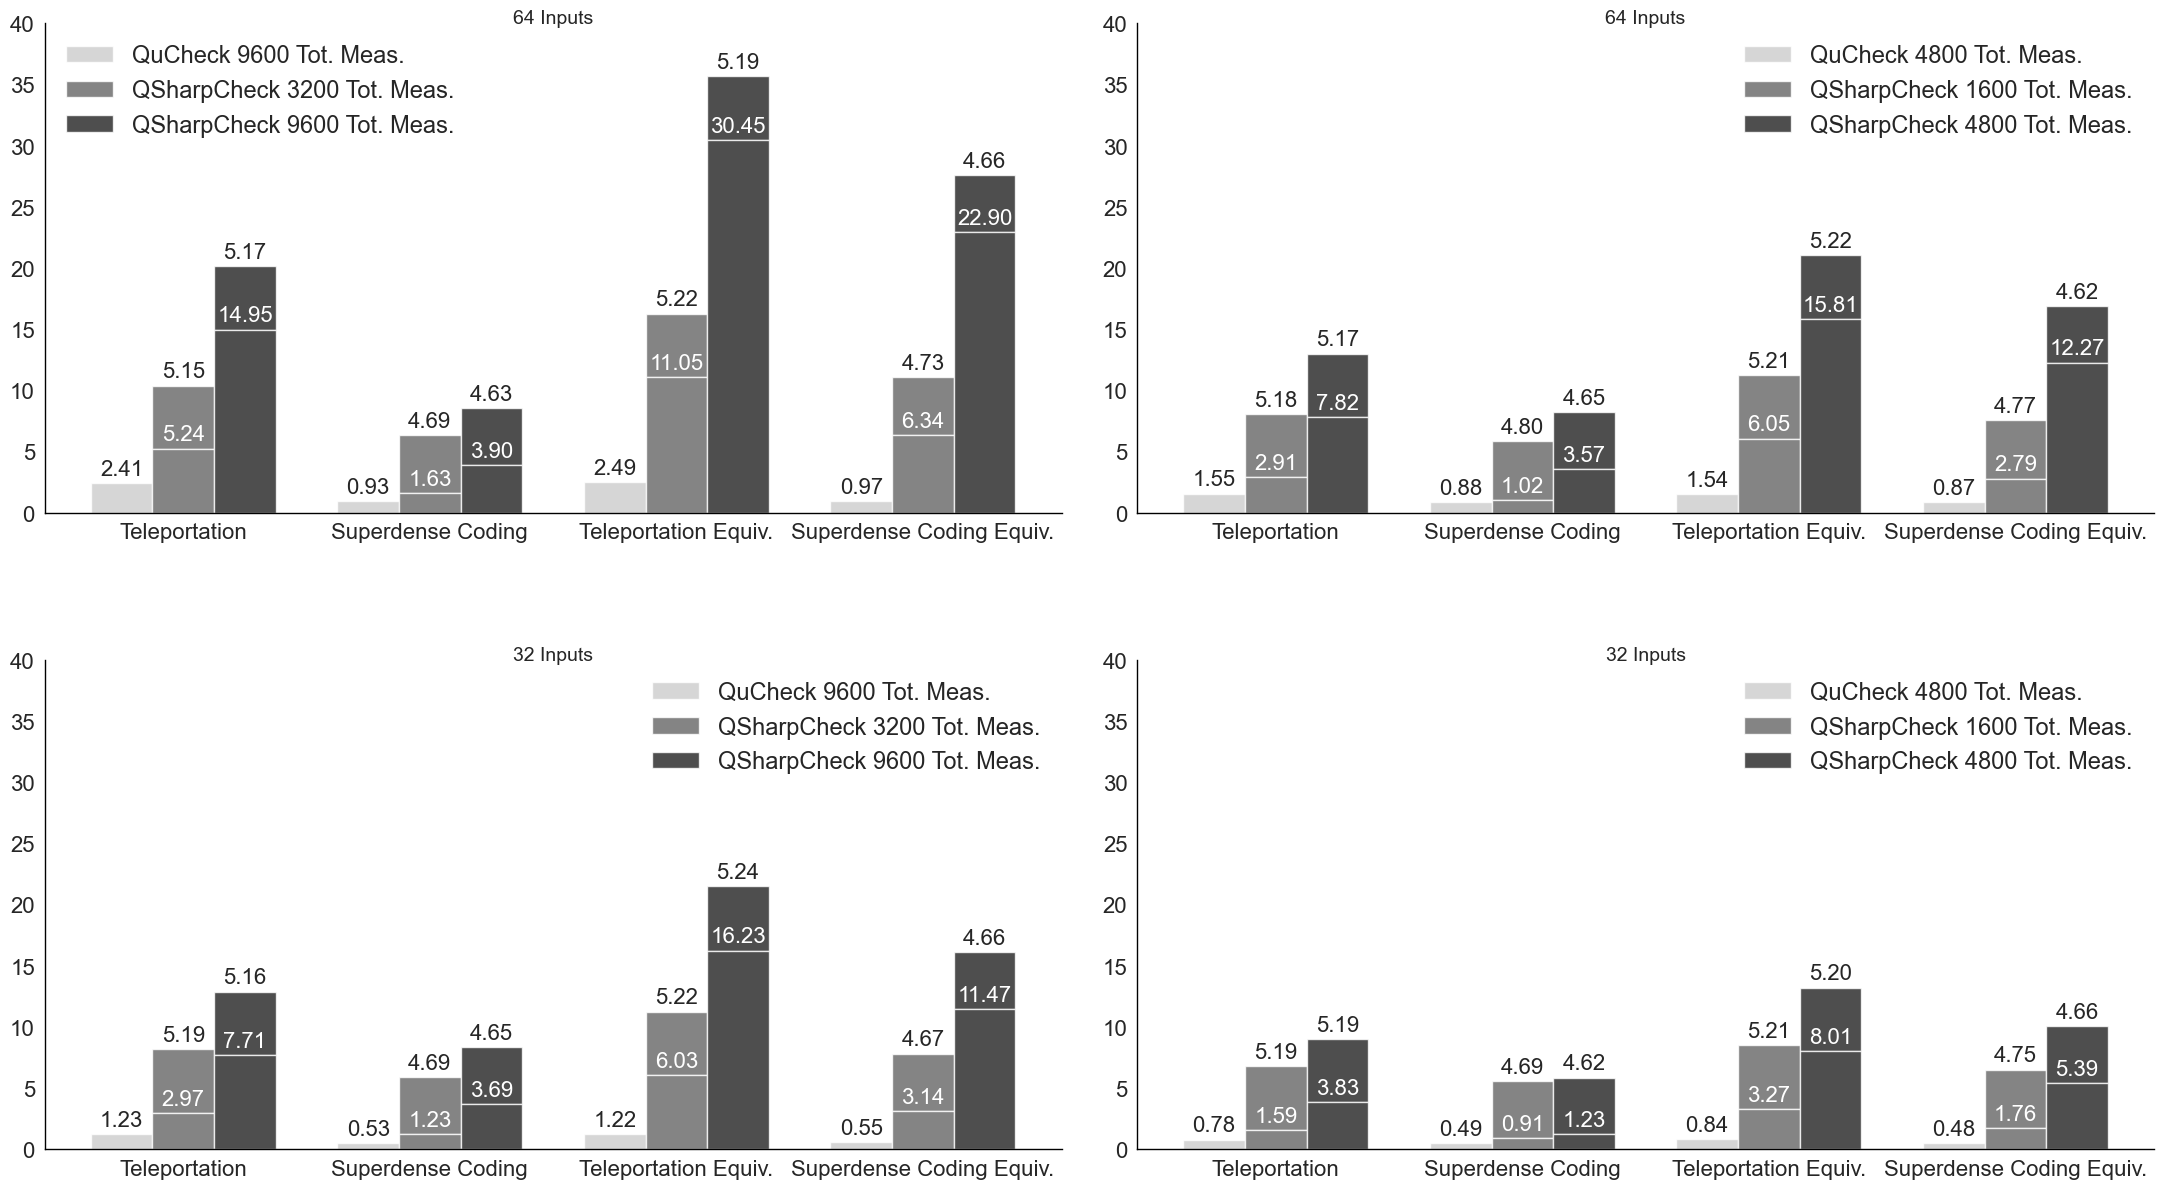

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_quantitative_analysis_comparison(qs_qt_df, qt_df, qs_sd_df, sd_df):
    # Define configurations
    configs = [
        {'measurements': 3200, 'inputs': 64},
        {'measurements': 1600, 'inputs': 64},
        {'measurements': 3200, 'inputs': 32},
        {'measurements': 1600, 'inputs': 32}
    ]

    fig, axes = plt.subplots(2, 2, figsize=(22, 12))
    # fig.suptitle('Comparison of Q# and Qiskit mutation testing of quantum teleportation', fontsize=16)

    for idx, config in enumerate(configs):
        ax = axes[idx // 2, idx % 2]

        # Filter data for the current configuration
        qs_qt_df_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == config['measurements']) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]

        qs_qt_df_long_filtered = qs_qt_df[
            (qs_qt_df['Number of Measurements'] == (config['measurements']*3)) &
            (qs_qt_df['Number of Inputs'] == config['inputs'])
        ]

        # Filter data for the current configuration
        qt_df_filtered = qt_df[
            (qt_df['Number of Measurements'] == config['measurements']) &
            (qt_df['Number of Inputs'] == config['inputs'])
        ]

        qs_sd_df_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == config['measurements']) &
            (qs_sd_df['Number of Inputs'] == config['inputs'])
        ]

        qs_sd_df_long_filtered = qs_sd_df[
            (qs_sd_df['Number of Measurements'] == (config['measurements']*3)) &
            (qs_sd_df['Number of Inputs'] == config['inputs'])
        ]

        sd_df_filtered = sd_df[
            (sd_df['Number of Measurements'] == config['measurements']) &
            (sd_df['Number of Inputs'] == config['inputs'])
        ]


        # Q# results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures = qs_qt_df_non_equivalent["Time Taken"].mean()
        qs_non_equiv_failures_compile = qs_qt_df_non_equivalent["Compile Time"].mean()

        qs_sd_df_non_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures = qs_sd_df_non_equivalent["Time Taken"].mean()
        qs_sd_non_equiv_failures_compile = qs_sd_df_non_equivalent["Compile Time"].mean()

        qs_qt_df_equivalent = qs_qt_df_filtered[qs_qt_df_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures = qs_qt_df_equivalent["Time Taken"].mean()
        qs_equiv_failures_compile = qs_qt_df_equivalent["Compile Time"].mean()

        qs_sd_df_equivalent = qs_sd_df_filtered[qs_sd_df_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures = qs_sd_df_equivalent["Time Taken"].mean()
        qs_sd_equiv_failures_compile = qs_sd_df_equivalent["Compile Time"].mean()

        # Q# long results (assumed to be the same for all configurations)
        qs_qt_df_non_equivalent_long = qs_qt_df_long_filtered[qs_qt_df_long_filtered['Mutant Name'].str.contains('_m')]
        qs_non_equiv_failures_long = qs_qt_df_non_equivalent_long["Time Taken"].mean()
        qs_non_equiv_failures_compile_long = qs_qt_df_non_equivalent_long["Compile Time"].mean()

        qs_sd_df_non_equivalent_long = qs_sd_df_long_filtered[qs_sd_df_long_filtered['Mutant Name'].str.contains('_m')]
        qs_sd_non_equiv_failures_long = qs_sd_df_non_equivalent_long["Time Taken"].mean()
        qs_sd_non_equiv_failures_compile_long = qs_sd_df_non_equivalent_long["Compile Time"].mean()

        qs_qt_df_equivalent_long = qs_qt_df_long_filtered[qs_qt_df_long_filtered['Mutant Name'].str.contains('_em')]
        qs_equiv_failures_long = qs_qt_df_equivalent_long["Time Taken"].mean()
        qs_equiv_failures_compile_long = qs_qt_df_equivalent_long["Compile Time"].mean()

        qs_sd_df_equivalent_long = qs_sd_df_long_filtered[qs_sd_df_long_filtered['Mutant Name'].str.contains('_em')]
        qs_sd_equiv_failures_long = qs_sd_df_equivalent_long["Time Taken"].mean()
        qs_sd_equiv_failures_compile_long = qs_sd_df_equivalent_long["Compile Time"].mean()

        # Qiskit results
        qt_df_non_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_m')]
        qt_non_equiv_failures = qt_df_non_equivalent["Time Taken"].mean()

        sd_df_non_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_m')]
        sd_non_equiv_failures = sd_df_non_equivalent["Time Taken"].mean()

        qt_df_equivalent = qt_df_filtered[qt_df_filtered['Mutant Name'].str.contains('_em')]
        qt_equiv_failures = qt_df_equivalent["Time Taken"].mean()

        sd_df_equivalent = sd_df_filtered[sd_df_filtered['Mutant Name'].str.contains('_em')]
        sd_equiv_failures = sd_df_equivalent["Time Taken"].mean()

        algorithms = ["Teleportation", "Superdense Coding", "Teleportation Equiv.", "Superdense Coding Equiv."]
        qiskit_results = np.array([qt_non_equiv_failures, sd_non_equiv_failures, qt_equiv_failures, sd_equiv_failures])
        qs_results = np.array([qs_non_equiv_failures, qs_sd_non_equiv_failures, qs_equiv_failures, qs_sd_equiv_failures])
        qs_results_compile = np.array([qs_non_equiv_failures_compile, qs_sd_non_equiv_failures_compile, qs_equiv_failures_compile, qs_sd_equiv_failures_compile])
        qs_results_long = np.array([qs_non_equiv_failures_long, qs_sd_non_equiv_failures_long, qs_equiv_failures_long, qs_sd_equiv_failures_long])
        qs_results_compile_long = np.array([qs_non_equiv_failures_compile_long, qs_sd_non_equiv_failures_compile_long, qs_equiv_failures_compile_long, qs_sd_equiv_failures_compile_long])


        # Create the plot
        x = np.arange(len(algorithms))
        width = 0.25

        grays = ["#CCCCCC", "#666666", "#222222"]

        rects1 = ax.bar(
            x - width, qiskit_results, width, color=grays[0],
            label=f'QuCheck {config["measurements"]*3} Tot. Meas.', alpha=0.8
        )

        # Plot compile time bars stacked on top of runtime bars
        rects4 = ax.bar(
            x, qs_results_compile, width, color=grays[1], alpha=0.8,
            bottom=qs_results
        )

        rects2 = ax.bar(
            x, qs_results, width, color=grays[1],
            label=f'QSharpCheck {config["measurements"]} Tot. Meas.', alpha=0.8
        )

        rects5 = ax.bar(
            x + width, qs_results_compile_long, width, color=grays[2], alpha=0.8,
            bottom=qs_results_long
        )

        rects3 = ax.bar(
            x + width, qs_results_long, width, color=grays[2],
            label=f'QSharpCheck {config["measurements"]*3} Tot. Meas.', alpha=0.8
        )

        ax.set_title(f'{config["inputs"]} Inputs', fontsize=14, pad=0)
        # ax.set_title(f'{config["inputs"]} Inputs', fontsize=14, pad=25)
        ax.set_xticks(x)
        ax.set_xticklabels(algorithms)

        ax.bar_label(rects1, padding=3, fontsize=16, labels=[f"{x:.2f}" for x in qiskit_results])
        ax.bar_label(rects2, padding=3, fontsize=16, color='white', labels=[f"{x:.2f}" for x in qs_results])
        ax.bar_label(rects3, padding=3, fontsize=16, color='white', labels=[f"{x:.2f}" for x in qs_results_long])
        ax.bar_label(rects4, padding=3, fontsize=16, labels=[f"{x:.2f}" for x in qs_results_compile])
        ax.bar_label(rects5, padding=3, fontsize=16, labels=[f"{x:.2f}" for x in qs_results_compile_long])

        for item in ax.get_xticklabels() + ax.get_xticklabels() + ax.get_yticklabels() + ax.get_yticklabels():
            item.set_fontsize(16)

        ax.set(ylabel=None)
        ax.spines['left'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend(frameon=False, fontsize=17)


        ax.set_ylim(0, 40.01)
        ax.grid(False)

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.3)
    # plt.savefig(f"quantitative_comparison_time.png", dpi=100, bbox_inches='tight')
    plt.savefig(f"quantitative_comparison_time.png", dpi=300, bbox_inches='tight')
    plt.show()
    # plt.show()

# To use this function, uncomment the following lines and run the script:
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df3 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
df4 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
plot_quantitative_analysis_comparison(df1, df2, df3, df4)

In [16]:
def clean_and_add_time(dfs_list):
    for df in dfs_list:
        df["Equivalent"] = df['Mutant Name'].str.contains('_em')
        df["Algorithm"] = df.apply(lambda x: x['Mutant Name'][:-4] if x['Equivalent'] else x['Mutant Name'][:-3], axis=1)
        return df

df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/QTQS_in_out.csv")
df2 = pd.read_csv(f"mutation_test_results/superdense_coding/SDQS_correct_bits.csv")
qsharp = pd.concat([df1, df2]) 
df1 = pd.read_csv(f"mutation_test_results/quantum_teleportation/quantum_teleportation_in_out_eq_merged_results.csv")
df2 = pd.read_csv(f"mutation_test_results/superdense_coding/superdense_coding_correct_bits_merged_results.csv")
qcheck = pd.concat([df1, df2])


In [17]:
qsharp = clean_and_add_time([qsharp])
get_stats(qsharp, group_by='Number of Measurements', filter_by_feature=['Number of Measurements', 'Number of Inputs'], filter_by_values=[[9600, 4800], [64, 32]], feature_str="Time Taken")

Not Equivalent
STD NE
Number of Measurements
4800     5.490410
9600    10.333194
Name: Time Taken, dtype: float64
Median NE
Number of Measurements
4800    0.405
9600    0.562
Name: Time Taken, dtype: float64
Mean NE
Number of Measurements
4800    4.113675
9600    7.563400
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.298154881983702, pvalue=0.007227054729978545)
Equivalent
STD E
Number of Measurements
4800    4.115160
9600    7.652407
Name: Time Taken, dtype: float64
Median E
Number of Measurements
4800    10.0165
9600    16.9265
Name: Time Taken, dtype: float64
Mean E
Number of Measurements
4800    10.3696
9600    20.2650
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.649722122736315, pvalue=5.71867400700329e-06)


In [24]:
# calculate mean execution time when measurements are 4800 and 9600, and inputs are 32 and 64 and equivalent mutants are included
Mean_NE_QS = (4.113675 + 7.563400)/2
print(Mean_NE_QS)
Mean_E_QS = (10.3696 + 20.2650)/2
print(Mean_E_QS)
Mean_NE_Qu = (0.925767 + 1.276825)/2
print(Mean_NE_Qu)
Mean_E_Qu = (0.934413 + 1.309050)/2
print(Mean_E_Qu)

NE_percent_decrease = ((Mean_NE_QS - Mean_NE_Qu) / Mean_NE_QS) * 100
print(NE_percent_decrease)
E_percent_decrease = ((Mean_E_QS - Mean_E_Qu) / Mean_E_QS) * 100
print(E_percent_decrease)

QS_mean = (Mean_NE_QS + Mean_E_QS) / 2
Qu_mean = (Mean_NE_Qu + Mean_E_Qu) / 2
Qu_QS_percent_decrease = ((QS_mean - Qu_mean) / QS_mean) * 100
print(Qu_QS_percent_decrease)

5.838537499999999
15.3173
1.101296
1.1217315
81.1374680731262
92.6767021603024
89.49213189976525


In [44]:
qcheck = clean_and_add_time([qcheck])
get_stats(qcheck, group_by='Number of Measurements', filter_by_feature=['Number of Measurements', 'Number of Inputs'], filter_by_values=[[3200, 1600], [64, 32]], feature_str="Time Taken")

Not Equivalent
STD NE
Number of Measurements
1600    0.398802
3200    0.712739
Name: Time Taken, dtype: float64
Median NE
Number of Measurements
1600    0.828869
3200    1.091990
Name: Time Taken, dtype: float64
Mean NE
Number of Measurements
1600    0.925767
3200    1.276825
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient NE
SignificanceResult(statistic=0.273901933371321, pvalue=0.013951544512979013)
Equivalent
STD E
Number of Measurements
1600    0.396656
3200    0.750434
Name: Time Taken, dtype: float64
Median E
Number of Measurements
1600    0.834700
3200    1.115898
Name: Time Taken, dtype: float64
Mean E
Number of Measurements
1600    0.934413
3200    1.309050
Name: Time Taken, dtype: float64
Pearson Correlation Coefficient E
SignificanceResult(statistic=0.3075351380951891, pvalue=0.0535549644631781)


In [3]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_bloch_vector
import numpy as np

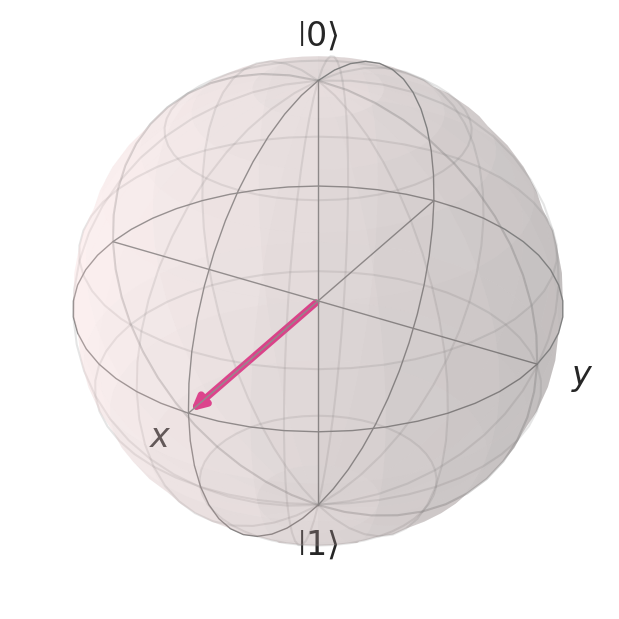

In [6]:
plot_bloch_vector([1, 0, 0], figsize=(6, 6), font_size=24, title="")

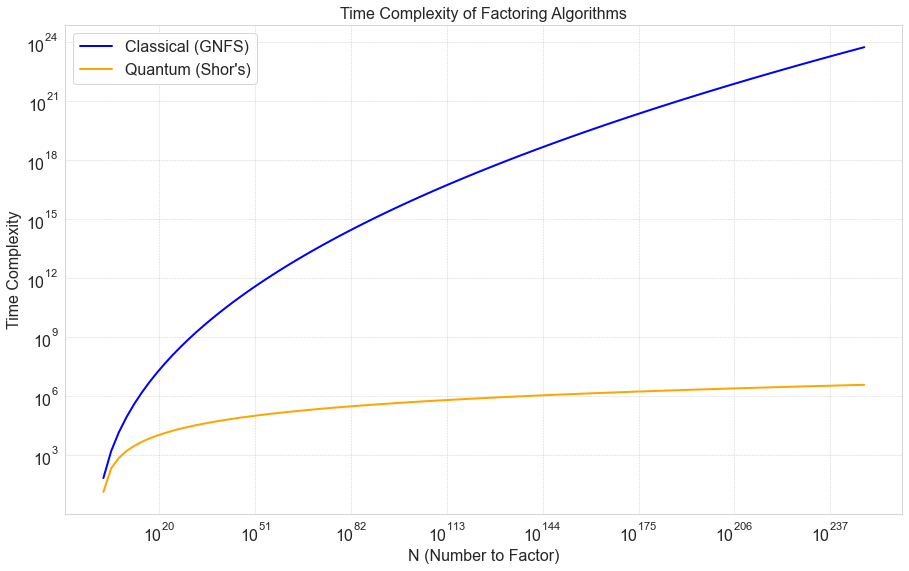

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Classical GNFS complexity: exp((64/9)^(1/3) * (ln(N))^(1/3) * (ln(ln(N)))^(2/3))
def gnfs_complexity(N):
    ln_N = np.log(N)
    return np.exp((64 / 9)**(1/3) * (ln_N)**(1/3) * (np.log(ln_N))**(2/3))

# Shor's algorithm complexity: (log(N))^2 * (log(log(N))) * (log(log(log(N))))
def shors_complexity(N):
    log_N = np.log(N)
    return (log_N**2) * np.log(log_N) * np.log(np.log(log_N))

# Generate a range of N values
N_values = np.logspace(2, 248, 100)  # From 10^2 to 10^8 (adjust range as needed)

# Calculate complexities
gnfs_values = [gnfs_complexity(N) for N in N_values]
shors_values = [shors_complexity(N) for N in N_values]

# Plotting
plt.figure(figsize=(15, 9))
plt.loglog(N_values, gnfs_values, label="Classical (GNFS)", linewidth=2, color="blue")
plt.loglog(N_values, shors_values, label="Quantum (Shor's)", linewidth=2, color="orange")
plt.title("Time Complexity of Factoring Algorithms", fontsize=16)
plt.xlabel("N (Number to Factor)", fontsize=16)
plt.ylabel("Time Complexity", fontsize=16)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.legend(fontsize=16)
plt.show()
